# Bibliotécas

In [11]:
import pandas                                          as pd
import seaborn                                         as sns
import sweetviz                                        as sv
import matplotlib.pyplot                               as plt
import numpy                                           as np
import pyarrow.parquet                                 as pq
import xgboost                                         as xgb
from scipy                   import stats              as ss
from statsmodels             import api                as sm
from sklearn                 import preprocessing      as pp
from sklearn                 import model_selection    as ms
from sklearn.preprocessing   import LabelEncoder       as le
from sklearn                 import neighbors          as nh 
from sklearn.utils           import resample
from sklearn.linear_model    import LogisticRegression
from skopt                   import BayesSearchCV
from sklearn.ensemble        import RandomForestClassifier
from sklearn.naive_bayes     import GaussianNB
from imblearn.over_sampling  import SMOTE
from sklearn.metrics         import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, make_scorer
from sklearn.ensemble        import ExtraTreesClassifier
from matplotlib.gridspec     import GridSpec
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
#import awswrangler                               as wr # Importando um driver para acessar outras instâncias da AWS
#import sagemaker
#from sagemaker import get_execution_role
#from sagemaker.amazon.amazon_estimator import get_image_uri
#from sagemaker.session import s3_input
import pickle
import os
import inflection
import warnings
warnings.filterwarnings('ignore')

# Funções

In [12]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [13]:
#Criando uma função para extrair os dados do Athena 
#def consultar_tabela_athena(database, tabela):
#    wr.config.aws_profile = 'default'
#    wr.config.region = 'us-east-1'
    
#    query = f'SELECT * FROM {database}.{tabela}'
#    df = wr.athena.read_sql_query(query, database = database)    
#    return df

import pandas as pd
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np

def validacao_cruzada(modelo, x, y, desbalanceado = False):
    kfold = KFold(n_splits = 5)

    if desbalanceado:
        print("Tamanho das classes não balanceadas:")
        print(y.value_counts())
    else:
        print("Tamanho das classes não balanceadas:")
        print(y.value_counts())

    resultados = {'acuracia': [], 
                  'precision': [], 
                  'recall': [],
                  'auc': []}

    for idx, (treino_idx, validacao_idx) in enumerate(kfold.split(x, y)):
        x_split_treino, x_split_validacao = x.iloc[treino_idx], x.iloc[validacao_idx]
        y_split_treino, y_split_validacao = y.iloc[treino_idx], y.iloc[validacao_idx]

        if desbalanceado:
            sm = SMOTE(random_state = 42)
            x_split_treino, y_split_treino = sm.fit_resample(x_split_treino, y_split_treino)

        # Treinamento do modelo
        modelo.fit(x_split_treino, y_split_treino.values.flatten())

        # Previsão das probabilidades
        pred_prob_validacao = modelo.predict_proba(x_split_validacao)

        # Previsão das classes
        pred_validacao = pred_prob_validacao.argmax(axis = 1)

        # Cálculo das métricas
        acuracia = accuracy_score(y_split_validacao, pred_validacao)
        precision = precision_score(y_split_validacao, pred_validacao, average = 'weighted')
        recall = recall_score(y_split_validacao, pred_validacao, average = 'weighted')
        auc_ = roc_auc_score(y_split_validacao, pred_prob_validacao, multi_class = 'ovr', average = 'weighted')

        # Armazenando os resultados
        resultados['acuracia'].append(acuracia)
        resultados['precision'].append(precision)
        resultados['recall'].append(recall)
        resultados['auc'].append(auc_)        

    # Cálculo das médias das métricas
    acuracia_media = np.mean(resultados['acuracia']) * 100
    precision_media = np.mean(resultados['precision']) * 100
    recall_media = np.mean(resultados['recall']) * 100
    auc_media = np.mean(resultados['auc'])

    # Criando um DataFrame com as médias das métricas
    df_resultados = pd.DataFrame({'acuracia': [f'{acuracia_media:.2f}%'],
                                  'precision': [f'{precision_media:.2f}%'],
                                  'recall': [f'{recall_media:.2f}%'],
                                  'auc': [f'{auc_media:.2f}']})

    # Obtendo o nome do algoritmo
    nome_algoritmo = type(modelo).__name__

    # Salvando os resultados em um arquivo CSV com o nome do algoritmo
    nome_arquivo = f"resultados_{nome_algoritmo}.csv"
    df_resultados.to_csv(nome_arquivo, index = False)

    if desbalanceado:
        print("\nTamanho das classes balanceadas:")
        print(pd.Series(y_split_treino).value_counts())

    # Imprimindo as métricas médias
    print("\nAcuracia: {:.2f}%".format(acuracia_media))
    print("Precisao: {:.2f}%".format(precision_media))
    print("Recall: {:.2f}%".format(recall_media))
    print("AUC: {:.2f}".format(auc_media))
    return resultados

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi_quadrado = ss.chi2_contingency(cm)[0]
    chi_quadrado_correcao = max(0, chi_quadrado - (k - 1) * (r -1) / (n -1))
    k_correcao = k - (k - 1) ** 2 / (n - 1)
    r_correcao = r - (r - 1) ** 2 / (n - 1)
    
    v = np.sqrt((chi_quadrado_correcao / n) / (min(k_correcao - 1, r_correcao -1)))
    return v

def descricao_estatistica_variaveis_numericas(df):
    #Métricas de tendência central: média e mediana
    central_1 = pd.DataFrame(df.apply(np.mean)).T
    central_2 = pd.DataFrame(df.apply(np.median)).T
    
    #Métricas de dispersão: desvio padrão, mínimo, máximo, aplitude, assimetrica e curtose
    dispersao_1 = pd.DataFrame(df.apply(np.std)).T
    dispersao_2 = pd.DataFrame(df.apply(np.min)).T
    dispersao_3 = pd.DataFrame(df.apply(np.max)).T
    dispersao_4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    dispersao_5 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    dispersao_6 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T
    
    metricas = pd.concat([dispersao_2, dispersao_3, dispersao_4, central_1, central_2, dispersao_1, dispersao_5, dispersao_6]).T
    metricas.columns = ['min', 'max', 'amplitude', 'mean', 'median', 'std', 'assimetria', 'kurtosis']
    return metricas

def descricao_estatistica_variaveis_categoricas(df):
    return df.apply(lambda x: x.unique().shape[0])

In [14]:
#database = 'base_de_dados_catalogados'
#tabela = 'tabela_traintrain'
#df = consultar_tabela_athena(database, tabela)

### Salvar os dados com o formato .parquet

In [15]:
# O formato Parquet é altamente eficiente em termos de armazenamento. Ele usa uma codificação eficiente para os dados,
# o que geralmente resulta em arquivos menores em comparação com outros formatos de armazenamento, como CSV ou JSON.

In [16]:
# Especificando quais colunas não quero carregar
colunas_a_excluir = ['SEM_NOT', 'SEM_PRI', 'ID_REGIONA', 'CO_REGIONA', 'COD_IDADE', 'CO_MUN_NOT',
                     'OBES_IMC', 'SG_UF', 'SURTO_SG', 'OUTRO_SIN', 'OUTRO_DES', 'OUT_MORBI', 'ID',
                     'MORB_DESC', 'MAE_VAC', 'M_AMAMENTA', 'RAIOX_OUT', 'OUT_AMOST', 'HISTO_VGM',
                     'PAC_COCBO', 'PAC_DSCBO', 'OUT_ANIM', 'TOMO_OUT', 'FNT_IN_COV', 'DELTA_UTI']

# Todas as colunas do dataset
todas_colunas = ['SEM_NOT', 'SEM_PRI', 'SG_UF_NOT', 'ID_REGIONA', 'CO_REGIONA', 'ID_MUNICIP', 'CO_MUN_NOT',
                 'CS_SEXO', 'NU_IDADE_N', 'TP_IDADE', 'COD_IDADE', 'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N',
                 'SG_UF', 'CS_ZONA', 'SURTO_SG', 'NOSOCOMIAL', 'AVE_SUINO', 'FEBRE', 'TOSSE', 'GARGANTA',
                 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'OUTRO_DES',
                 'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA',
                 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OBES_IMC',
                 'OUT_MORBI', 'MORB_DESC', 'VACINA', 'MAE_VAC', 'M_AMAMENTA', 'ANTIVIRAL', 'TP_ANTIVIR',
                 'HOSPITAL', 'UTI', 'SUPORT_VEN', 'RAIOX_RES', 'RAIOX_OUT', 'AMOSTRA', 'TP_AMOSTRA',
                 'OUT_AMOST', 'CLASSI_FIN', 'HISTO_VGM', 'PAC_COCBO', 'PAC_DSCBO', 'OUT_ANIM', 'DOR_ABD',
                 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'TOMO_RES', 'TOMO_OUT', 'VACINA_COV', 'DOSE_1_COV',
                 'DOSE_2_COV', 'DOSE_REF', 'FNT_IN_COV', 'DELTA_UTI', 'ID']

# Identificando quais colunas quero carregar
colunas_desejadas = [coluna for coluna in todas_colunas if coluna not in colunas_a_excluir]

# Carregar o dataset com as colunas desejadas
file_path = '../dataset/train.csv'
df = pd.read_csv(file_path, usecols = colunas_desejadas)

# Otimizando os tipos de dados
#df = optimize_dtypes(df)

In [17]:
df.to_parquet('../dataset/reduzido.parquet')

* Como o dataset é muito grande, obtou-se em pegar uma amostra menor dos dados para as devidas análises

In [18]:
df = df.sample(frac = 0.4, weights = 'CLASSI_FIN', random_state = 42)

In [19]:
df.columns

Index(['SG_UF_NOT', 'ID_MUNICIP', 'CS_SEXO', 'NU_IDADE_N', 'TP_IDADE',
       'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'CS_ZONA', 'NOSOCOMIAL',
       'AVE_SUINO', 'FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP',
       'SATURACAO', 'DIARREIA', 'VOMITO', 'PUERPERA', 'FATOR_RISC',
       'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES',
       'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE',
       'VACINA', 'ANTIVIRAL', 'TP_ANTIVIR', 'HOSPITAL', 'UTI', 'SUPORT_VEN',
       'RAIOX_RES', 'AMOSTRA', 'TP_AMOSTRA', 'CLASSI_FIN', 'DOR_ABD', 'FADIGA',
       'PERD_OLFT', 'PERD_PALA', 'TOMO_RES', 'VACINA_COV', 'DOSE_1_COV',
       'DOSE_2_COV', 'DOSE_REF'],
      dtype='object')

In [20]:
# Estes dados serão utilizados como dados de produção no futuro
dados_brutos_que_vieram_da_producao = pd.read_parquet('../dataset/reduzido.parquet')

In [21]:
df.shape

(520392, 51)

In [22]:
# Obs.: Como os dados estão salvos em memória, não é preciso mais consultar o Athena para trazer os dados

# 1. (Limpeza dos dados) Passo 1: Descrição dos dados

### 1.1 Descrição das colunas (dicionário de dados)

**SEM_NOT** – Semana Epidemiológica do preenchimento da ficha de notificação.

**SEM_PRI** – Semana Epidemiológica dos Primeiros Sintomas.

**SG_UF_NOT** – Tabela com código e siglas das UF padronizados pelo IBGE.

**(4) ID_REGIONA** – Regional de Saúde de Notificação Código IBGE.
Município realizou a notificação.

**CO_REGIONA** – Regional de Saúde de Notificação Código IBGE.
Município realizou a notificação.

**(5) ID_MUNICIP** – Município Código IBGE.
Unidade que realizou a notificação.

**CO_MUN_NOT** – Município Código IBGE.
Unidade que realizou a notificação.

**(8) CS_SEXO** – Sexo do paciente.

**NU_IDADE_N** – Idade informada pelo paciente.
Quando não se sabe a data de nascimento é registrada a idade aparente. Se digitado a data de nascimento a idade é calculada automaticamente pelo sistema considerando o intervalo entre a data de nascimento e a data dos primeiros sintomas. A idade deve ser <= 150.

**(10) TP_IDADE** – Tipo de idade.
1 – Dia;
2 – Mês;
3 – Ano.
Se digitado a data de nascimento, o campo Idade/Tipo é calculado e preenchido automaticamente pelo sistema: considerando o intervalo entre a data de nascimento e a data dos primeiros sintomas. Se a diferença for de 0 a 30 dias, o sistema grava em Idade = (nº dias) e em Tipo = 1 – Dia. Por exemplo: se Data de nascimento = 05/12/2012 e Data dos 1ºs sintomas = 11/12/2012, então Idade = 6 e Tipo = 1 – Dia. Se a diferença for de 1 a 11 meses, o sistema grava em Idade = (nº meses) e em Tipo = 2 – Mês. Por exemplo: se Data de nascimento = 05/10/2012 e Data dos 1ºs sintomas = 11/12/2012, então Idade = 2 e Tipo = 2 – Mês. Se a diferença for maior ou igual a 12 meses, o sistema grava em Idade = (nº anos) e em Tipo = 3 – Ano. Por exemplo: se Data de nascimento = 05/10/2011 e Data dos 1ºs sintomas = 11/12/2012, então Idade = 1 e Tipo = 3 – Ano.

**COD_IDADE** – Não existe a descrição no dicionário de dados.

**(11) CS_GESTANT** – Gestante Idade gestacional da paciente. 
1 – 1º Trimestre;
2 – 2º Trimestre;
3 – 3º Trimestre;
4 – Idade Gestacional Ignorada;
5 – Não;
6 – Não se aplica;
9 – Ignorado.
Se selecionado categoria 2 – Feminino no campo Sexo. Se selecionado sexo igual a Masculino ou a idade for menor ou igual a 9 anos, o campo é preenchido automaticamente com 6 – Não se aplica. Se selecionado sexo igual a Feminino e idade for maior que 9 anos, o campo não pode ser preenchido com 6 – Não se aplica.

**(12) CS_RACA** – Raça/Cor declarada pelo paciente.
1 – Branca;
2 – Preta;
3 – Amarela;
4 – Parda;
5 – Indígena;
9 – Ignorado.

**(14) CS_ESCOL_N** – Escolaridade.
0 – Sem escolaridade;
1 – Fundamental 1º ciclo (1ª a 5ª série);
2 – Fundamental 2º ciclo (6ª a 9ª série);
3 – Médio (1º ao 3º ano);
4 – Superior;
5 – Não se aplica;
9 – Ignorado.

**(18) SG_UF** – UF.
Unidade federativa de residência do paciente.

**(25) CS_ZONA** – Zona geográfica de residência do paciente.
1 – Urbana;
2 – Rural;
3 – Periurbana;
9 – Ignorado.

**SURTO_SG** – Não está no dicionário.

**(33) NOSOCOMIAL** – Trata–se de caso nosocomial (infecção adquirida no hospital)?.
1 – Sim;
2 – Não;
9 – Ignorado.

**(34) AVE_SUINO** – Paciente trabalha ou tem contato direto com aves, suínos, ou outro animal?.
1 – Sim;
2 – Não;
9 – Ignorado.

**(35) FEBRE** – Sinais e Sintomas/Febre.
1 – Sim;
2 – Não;
9 – Ignorado.

<span style="color:blue">**(35) TOSSE**</span> – Sinais e Sintomas/Tosse.
1 – Sim;
2 – Não;
9 – Ignorado.

**(35) GARGANTA** – Sinais e Sintomas/Dor de Garganta.
1 – Sim;
2 – Não;
9 – Ignorado.

**(35) DISPNEIA** – Sinais e Sintomas/Dispneia (sensação de falta de ar).
1 – Sim;
2 – Não;
9 – Ignorado.

**(35) DESC_RESP** – Sinais e sintomas/desconforto respiratórios.
1 – Sim;
2 – Não;
9 – Ignorado.

**(35) SATURACAO** – Sinais e Sintomas/Saturação O2< 95%.
1 – Sim;
2 – Não;
9 – Ignorado.

**(35) DIARREIA** – Sinais e Sintomas/Diarreia.
1 – Sim;
2 – Não;
9 – Ignorado.

**(35) VÔMITO** – Sinais e Sintomas/Vômito.
1 – Sim;
2 – Não;
9 – Ignorado.

**(35) DOR_ABD** – Sinais e Sintomas/Dor abdominal.
1 – Sim;
2 – Não;
9 – Ignorado.

**(35) FADIGA** – Sinais e Sintomas/Fadiga.
1 – Sim;
2 – Não;
9 – Ignorado.

**(35) ERD_OLFT** – Sinais e Sintomas/Perda do Olfato.
1 – Sim;
2 – Não;
9 – Ignorado.

**(35) PERD_PALA** – Sinais e Sintomas/Perda do Paladar.
1 – Sim;
2 – Não;
9 – Ignorado.

**(35) OUTRO_SIN** – Sinais e Sintomas/Outros.
(String)

**(36) FATOR_RISC** – Fatores de risco (possui algum?).
1 – Sim;
2 – Não;
9 – Ignorado.

**(36) PUERPERA** – Fatores de risco/Puérpera ou parturiente (mulher que pariu recentemente – até 45 dias do parto)?.
1 – Sim;
2 – Não;
9 – Ignorado.

**(36) CARDIOPATI** – Fatores de risco/Cardiovascular Crônica Doença.
1 – Sim;
2 – Não;
9 – Ignorado.

**(36) HEMATOLOGI** – Fatores de risco/Doença hematológica crônica.
1 – Sim;
2 – Não;
9 – Ignorado.

**(36) SIND_DOWN** – Fatores de risco/Síndrome de Down.
1 – Sim;
2 – Não;
9 – Ignorado.

**(36) HEPATICA** – Fatores de risco/Doença Hepática Crônica.
1 – Sim;
2 – Não;
9 – Ignorado.

**(36) ASMA** – Fatores de risco/ Asma.
1 – Sim;
2 – Não;
9 – Ignorado.

**(36) DIABETES** – Fatores de risco/Diabetes mellitus.
1 – Sim;
2 – Não;
9 – Ignorado.

**(36) NEUROLOGIC** – Fatores de risco/doença Neurológica Crônica.
1 – Sim;
2 – Não;
9 – Ignorado.

**(36) PNEUMOPATI** – Fatores de risco/outra Pneumatopatia Crônica (doenças que afetam os pulmões).
1 – Sim;
2 – Não;
9 – Ignorado.

**(36) IMUNODEPRE** – Fatores de risco/Imunodeficiência ou Imunodepressão.
1 – Sim;
2 – Não;
9 – Ignorado.

**(36) RENAL** – Fatores de risco/Doença Renal Crônica.
1 – Sim;
2 – Não;
9 – Ignorado.

**(36) OBESIDADE** – Fatores de risco/Obesidade.
1 – Sim;
2 – Não;
9 – Ignorado.

**(36) OBES_IMC** – Fatores de (Descrição IMC).
Campo habilitado somente se selecionado 1 (Sim) no campo OBESIDADE.

**OUT_MORBI** – Fatores de risco/Outros.
1 – Sim;
2 – Não;
9 – Ignorado.

**MORB_DESC** – Fatores de risco/outros(descrição).
Habilitado se selecionado categoria 1–Sim em Fatores de risco/Outros. OUT_MORBI

**(37) VACINA** – Recebeu vacina contra Gripe na última campanha?.
1 – Sim;
2 – Não;
9 – Ignorado.

**MAE_VAC** – Se < 6 meses: a mãe recebeu a vacina?.
1 – Sim;
2 – Não;
9 – Ignorado.

**M_AMAMENTA** – Se < 6 meses: a mãe amamenta a criança?.
1 – Sim;
2 – Não;
9 – Ignorado.

**(39) ANTIVIRAL** – Usou antiviral para gripe?.
1 – Sim;
2 – Não;
9 – Ignorado.

**(40) TP_ANTIVIR** – Qual antiviral?. Habilitado se campo 39 (ANTIVIRAL) Usou antiviral para gripe? for igual a 1. 
1 – Oseltamivir;
2 – Zanamivir;
3 – Outro, especifique.

**(42) HOSPITAL** – Houve internação?. Caso o campo não seja igual a 1 – Sim o sistema emitirá um aviso indicando que não atende a definição de caso.
1 – Sim;
2 – Não;
9 – Ignorado.

**(47) UTI** – Internado em UTI?.
1 – Sim;
2 – Não;
9 – Ignorado.

**(50) SUPORT_VEN** – Uso de suporte ventilatório?. Suporte ventilatório no intuito de facilitar as trocas gasosas, reduzir a fadiga muscular, reduzir a dispneia, melhorar a ventilação alveolar, aumentar a complacência pulmonar e a capacidade residual funcional, diminuir a morbidade e manter as vias aéreas abertas sem a necessidade de instituir uma via aérea.
1 – Sim, invasivo;
2 – Sim, não invasivo;
3 – Não;
9 – Ignorado.

**(51) RAIOX_RES** – Raio X de Tórax.
1 – Normal;
2 – Infiltrado intersticial;
3 – Consolidação;
4 – Misto;
5 – Outro;
6 – Não realizado;
9 – Ignorado.

**RAIOX_OUT** – Raio X de Tórax/Outro (especificar). Informar o resultado do RX de tórax se selecionado a opção 5–Outro.
Habilitado de campo 57(RAIOX_RES) – Raio X de Tórax = 5 (Outro).

**(53) AMOSTRA** – Coletou amostra. Foi realizado coleta de amostra para realização de teste diagnóstico?
1 – Sim;
2 – Não;
9 – Ignorado.

**(55) TP_AMOSTRA** – Tipo de amostra.
1 – Secreção de Naso–orofaringe;
2 – Lavado Broco–alveolar;
3 – Tecido post–mortem;
4 – Outra, qual?;
5 – LCR;
9 – Ignorado.

**OUT_AMOST** – Tipo de amostra/Outra. Descrição do tipo da amostra clínica, caso diferente das listadas nas categorias do campo.
Campo habilitado se selecionado categoria 4–Outra, qual em Tipo de amostra. em coluna TP_AMOSTRA

<span style="color:red">**CLASSI_FIN**</span> – Classificação final do caso –– TARGET.
1 – SRAG por influenza;
2 – SRAG por outro vírus respiratório;
3 – SRAG por outro agente etiológico qual;
4 – SRAG não especificado;
5 – SRAG por covid–19.

<span style="color:blue">**HISTO_VGM**</span> – Não está no dicionário. Histórico de viagem internacional.

**PAC_COCBO** – Ocupação profissional do paciente.

**PAC_DSCBO** – Ocupação profissional do paciente.

**OUT_ANIM** – Paciente trabalha ou tem contato direto com aves, suínos/Outro animal (especificar). Informar o animal que o paciente teve contato se selecionado a opção 3.
Habilitado de campo 33(AVE_SUINO) – Contato com outro animal = 3 (Outro).

**TOMO_RES** – Aspecto Tomografia.
1 – Tipico covid–19;
2 – Indeterminado covid–19;
3 – Atípico covid–19;
4 – Negativo para Pneumonia;
5 – Outro;
6 – Não realizado;
9 – Ignorado.

**TOMO_OUT** – Aspecto Tomografia/Outro (especificar). Informar o resultado da tomografia se selecionado a opção 5 –Outro
Habilitado de campo 59 (TOMO_RES ) – Aspecto Tomografia = 5

**VACINA_COV** – Recebeu vacina COVID–19?.
1 – Sim;
2 – Não;
9 – Ignorado.

**DOSE_1_COV** – Data 1ª dose da vacina COVID–19.
Habilitado se campo 36(VACINA_COV) – Recebeu vacina COVID–19? for igual a 1.

**DOSE_2_COV** – Data 2ª dose da vacina COVID–19
Habilitado se campo 36(VACINA_COV) – Recebeu vacina COVID–19? for igual a 1.

**DOSE_REF** – Data da dose reforço da vacina COVID–19
Habilitado se campo 36(VACINA_COV) – Recebeu vacina COVID–19? for igual a 1.

**FNT_IN_COV** – Fonte dos dados/informação sobre a vacina COVID–19
Campo preenchido de acordo com a fonte dos dados/informação sobre a vacina COVID–19, se foi digitada manualmente ou recuperada via integração com a Base Nacional de Vacinação.
1 – Manual;
2 – Integração.

**DELTA_UTI** – Não está no dicionário de dados.

**ID** – Não está no dicionário de dados.

### 1.2 Carregar os dados

In [23]:
df1 = df.copy()

### 1.3 Dimensão dos dados

In [24]:
df1.shape

(520392, 51)

### 1.4 Editar as colunas

In [25]:
df1.columns

Index(['SG_UF_NOT', 'ID_MUNICIP', 'CS_SEXO', 'NU_IDADE_N', 'TP_IDADE',
       'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'CS_ZONA', 'NOSOCOMIAL',
       'AVE_SUINO', 'FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP',
       'SATURACAO', 'DIARREIA', 'VOMITO', 'PUERPERA', 'FATOR_RISC',
       'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES',
       'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE',
       'VACINA', 'ANTIVIRAL', 'TP_ANTIVIR', 'HOSPITAL', 'UTI', 'SUPORT_VEN',
       'RAIOX_RES', 'AMOSTRA', 'TP_AMOSTRA', 'CLASSI_FIN', 'DOR_ABD', 'FADIGA',
       'PERD_OLFT', 'PERD_PALA', 'TOMO_RES', 'VACINA_COV', 'DOSE_1_COV',
       'DOSE_2_COV', 'DOSE_REF'],
      dtype='object')

In [26]:
df1.columns = df1.columns.str.lower()

In [27]:
df1.columns

Index(['sg_uf_not', 'id_municip', 'cs_sexo', 'nu_idade_n', 'tp_idade',
       'cs_gestant', 'cs_raca', 'cs_escol_n', 'cs_zona', 'nosocomial',
       'ave_suino', 'febre', 'tosse', 'garganta', 'dispneia', 'desc_resp',
       'saturacao', 'diarreia', 'vomito', 'puerpera', 'fator_risc',
       'cardiopati', 'hematologi', 'sind_down', 'hepatica', 'asma', 'diabetes',
       'neurologic', 'pneumopati', 'imunodepre', 'renal', 'obesidade',
       'vacina', 'antiviral', 'tp_antivir', 'hospital', 'uti', 'suport_ven',
       'raiox_res', 'amostra', 'tp_amostra', 'classi_fin', 'dor_abd', 'fadiga',
       'perd_olft', 'perd_pala', 'tomo_res', 'vacina_cov', 'dose_1_cov',
       'dose_2_cov', 'dose_ref'],
      dtype='object')

### 1.5 Verificar NA's

In [28]:
df1_NaN = df1.isna().mean().round(4) * 100
sum(df1_NaN)

1423.7199999999998

#### 1.5.1 Substituir NA's

In [29]:
# A variável 'cs_gestant' deve conter os dados 1, 2, 3, 4, 5, 6 e 9. Portanto, os valores diferentes deste foram alterados para 9 (Outro)
df1['cs_gestant'] = df1['cs_gestant'].apply(lambda x: x if x in [1, 2, 3, 4, 5, 6, 9] else 9)

# Se a variável 'cs_sexo' é igual a M, então os dados da variável 'cs_gestant' deveriam ser igual a 6 (Não se aplica) 
df1.loc[df1['cs_sexo'] == 'M', 'cs_gestant'] = 6

# A variável 'ave_suino' deve conter os dados 1, 2 e 9. Portanto, os valores diferentes deste foram alterados para 9 (Outro)
df1['ave_suino'] = df1['ave_suino'].apply(lambda x: x if x in [1, 2, 9] else 9)

# A variável 'tp_antivir' deve conter os dados 1, 2 e 3. Portanto, os valores diferentes deste foram alterados para 3 (Outro)
df1.loc[df1['tp_antivir'] == 9, 'tp_antivir'] = 3

# A variável 'hospital' deve conter os dados 1, 2 e 9. Portanto, os valores diferentes deste foram alterados para 9 (Outro)
df1.loc[df1['hospital'] == 3, 'hospital'] = 9

# A variável 'uti' deve conter os dados 1, 2 e 9. Portanto, os valores diferentes deste foram alterados para 9 (Outro)
df1.loc[df1['uti'] == 3, 'uti'] = 9

# Se a variável 'tp_antivir' é NaN e a variável 'antiviral' é 1, então 'tp_antivir' é definida como 3
df1['tp_antivir'] = df1.apply(lambda x: 3 if pd.isna(x['tp_antivir']) and x['antiviral'] == 1 else x['tp_antivir'], axis = 1)

# Devido à alta incidência de valores ausentes (NaN) na variável 'tp_antivir', foi decidido atribuir o valor de 0 (zero) sempre que a variável 'antiviral'
# estiver marcada como 2 ou 9. Essa abordagem foi escolhida para preencher os dados faltantes e garantir a integridade do conjunto de dados
df1['tp_antivir'] = df1.apply(lambda x: 0 if pd.isna(x['tp_antivir']) and (x['antiviral'] == 2 or x['antiviral'] == 9) else x['tp_antivir'], axis = 1)

#### 1.5.2 Excluir NA's

In [30]:
# A variável 'cs_sexo' deve conter os dados igual a M ou F. Portanto, os valores diferentes deste foram excluídos
df1 = df1[df1['cs_sexo'].isin(['M', 'F'])]

# A variável 'amostra' deve conter os dados 1, 2, 3, 4, 5 e 9. Portanto, os valores diferentes deste foram excluídos
df1 = df1[df1['amostra'].isin([1, 2, 9])]

# A variável 'tp_amostra' deve conter os dados 1, 2, 3, 4, 5 e 9. Portanto, os valores diferentes deste foram excluídos
df1 = df1[df1['tp_amostra'].isin([1, 2, 3, 4, 5, 9])]

# A variável 'classi_fin' deve conter os dados 1, 2, 3, 4 e 5. Portanto, os valores diferentes deste foram excluídos
df1 = df1[df1['classi_fin'].isin([1, 2, 3, 4, 5])]

# A variável 'dose_1_cov' deve conter os dados 0 e 1. Portanto, os valores diferentes deste foram excluídos
df1 = df1[df1['dose_1_cov'].isin([0, 1])]

# A variável 'dose_ref' deve conter os dados 0 e 1. Portanto, os valores diferentes deste foram excluídos
df1 = df1[df1['dose_ref'].isin([0, 1])]

In [31]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472414 entries, 522218 to 642333
Data columns (total 51 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   sg_uf_not   472414 non-null  object 
 1   id_municip  472414 non-null  object 
 2   cs_sexo     472414 non-null  object 
 3   nu_idade_n  472414 non-null  int64  
 4   tp_idade    472414 non-null  int64  
 5   cs_gestant  472414 non-null  int64  
 6   cs_raca     472414 non-null  int64  
 7   cs_escol_n  311519 non-null  float64
 8   cs_zona     426297 non-null  float64
 9   nosocomial  404145 non-null  float64
 10  ave_suino   472414 non-null  float64
 11  febre       390956 non-null  float64
 12  tosse       412124 non-null  float64
 13  garganta    333292 non-null  float64
 14  dispneia    411610 non-null  float64
 15  desc_resp   380931 non-null  float64
 16  saturacao   395971 non-null  float64
 17  diarreia    327529 non-null  float64
 18  vomito      324058 non-null  float64
 19  pu

In [32]:
# Encontrar o número máximo de linhas não nulas em qualquer coluna
max_non_null_count = df1.count().max()

# Filtrar colunas que possuem menos de max_non_null_count valores não nulos
colunas_incompletas = df1.columns[df1.notnull().sum() < max_non_null_count]

# Mostrar informações sobre essas colunas
print(f"Colunas com menos de {max_non_null_count} valores não nulos:\n{colunas_incompletas}\n")

Colunas com menos de 472414 valores não nulos:
Index(['cs_escol_n', 'cs_zona', 'nosocomial', 'febre', 'tosse', 'garganta',
       'dispneia', 'desc_resp', 'saturacao', 'diarreia', 'vomito', 'puerpera',
       'cardiopati', 'hematologi', 'sind_down', 'hepatica', 'asma', 'diabetes',
       'neurologic', 'pneumopati', 'imunodepre', 'renal', 'obesidade',
       'vacina', 'antiviral', 'tp_antivir', 'hospital', 'uti', 'suport_ven',
       'raiox_res', 'dor_abd', 'fadiga', 'perd_olft', 'perd_pala', 'tomo_res',
       'vacina_cov'],
      dtype='object')



In [33]:
# Inserindo 9 - Não aplicável nas linhas com NaN
colunas_a_preencher = ['cs_escol_n', 'cs_zona', 'nosocomial', 'febre', 'tosse', 'garganta',
                       'dispneia', 'desc_resp', 'saturacao', 'diarreia', 'vomito', 'puerpera',
                       'cardiopati', 'hematologi', 'sind_down', 'hepatica', 'asma', 'diabetes',
                       'neurologic', 'pneumopati', 'imunodepre', 'renal', 'obesidade',
                       'vacina', 'antiviral', 'tp_antivir', 'hospital', 'uti', 'suport_ven',
                       'raiox_res', 'dor_abd', 'fadiga', 'perd_olft', 'perd_pala', 'tomo_res',
                       'vacina_cov']

# Criando um dicionário com o valor 9 para todas as colunas
valores_a_preencher = {coluna: 9 for coluna in colunas_a_preencher}

# Preenchendo os valores nulos
df1 = df1.fillna(valores_a_preencher)

#### 1.5.3 Verificar NA's novamente

In [34]:
df1_NaN = df1.isna().mean().round(4) * 100
sum(df1_NaN)

0.0

### 1.6 Tipo de dados

In [35]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472414 entries, 522218 to 642333
Data columns (total 51 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   sg_uf_not   472414 non-null  object 
 1   id_municip  472414 non-null  object 
 2   cs_sexo     472414 non-null  object 
 3   nu_idade_n  472414 non-null  int64  
 4   tp_idade    472414 non-null  int64  
 5   cs_gestant  472414 non-null  int64  
 6   cs_raca     472414 non-null  int64  
 7   cs_escol_n  472414 non-null  float64
 8   cs_zona     472414 non-null  float64
 9   nosocomial  472414 non-null  float64
 10  ave_suino   472414 non-null  float64
 11  febre       472414 non-null  float64
 12  tosse       472414 non-null  float64
 13  garganta    472414 non-null  float64
 14  dispneia    472414 non-null  float64
 15  desc_resp   472414 non-null  float64
 16  saturacao   472414 non-null  float64
 17  diarreia    472414 non-null  float64
 18  vomito      472414 non-null  float64
 19  pu

#### 1.6.1 Editar os tipos de dados

In [36]:
# Lista das colunas que serão convertidas
colunas_float_e_int = df1.select_dtypes(include = ['number']).columns

# Convertendo as colunas float64 para int64
df1[colunas_float_e_int] = df1[colunas_float_e_int].astype('int8')

### 1.7 Descrição estatística do negócio

#### 1.7.1 Atributos numéricos

In [37]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472414 entries, 522218 to 642333
Data columns (total 51 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   sg_uf_not   472414 non-null  object
 1   id_municip  472414 non-null  object
 2   cs_sexo     472414 non-null  object
 3   nu_idade_n  472414 non-null  int8  
 4   tp_idade    472414 non-null  int8  
 5   cs_gestant  472414 non-null  int8  
 6   cs_raca     472414 non-null  int8  
 7   cs_escol_n  472414 non-null  int8  
 8   cs_zona     472414 non-null  int8  
 9   nosocomial  472414 non-null  int8  
 10  ave_suino   472414 non-null  int8  
 11  febre       472414 non-null  int8  
 12  tosse       472414 non-null  int8  
 13  garganta    472414 non-null  int8  
 14  dispneia    472414 non-null  int8  
 15  desc_resp   472414 non-null  int8  
 16  saturacao   472414 non-null  int8  
 17  diarreia    472414 non-null  int8  
 18  vomito      472414 non-null  int8  
 19  puerpera    472414 non-

In [38]:
atributos_numericos = df1.select_dtypes(include = ['int8'])
atributos_categoricos = df1.select_dtypes(exclude = ['int8'])

In [39]:
descricao_estatistica_variaveis_numericas(atributos_numericos)

,min,max,amplitude,mean,median,std,assimetria,kurtosis
nu_idade_n,-120.0,124.0,-12.0,53.431359,57.0,24.457658,-0.575123,-0.367871
tp_idade,1.0,3.0,2.0,2.955052,3.0,0.225177,-5.373438,31.127011
cs_gestant,1.0,9.0,8.0,5.776590,6.0,0.857586,1.240349,7.751892
cs_raca,1.0,9.0,8.0,3.404719,4.0,2.822786,1.014923,-0.202892
cs_escol_n,0.0,9.0,9.0,6.588725,9.0,3.318336,-0.776717,-1.166527
cs_zona,1.0,9.0,8.0,1.933569,1.0,2.493055,2.454858,4.098714
nosocomial,1.0,9.0,8.0,3.446839,2.0,2.863569,1.416746,0.026156
ave_suino,1.0,9.0,8.0,4.123739,2.0,3.228976,0.845917,-1.279339
febre,1.0,9.0,8.0,2.778652,1.0,2.989291,1.548291,0.523254
tosse,1.0,9.0,8.0,2.288508,1.0,2.702848,2.026018,2.246683


#### 1.7.2 Atributos categóricos

In [40]:
descricao_estatistica_variaveis_categoricas(atributos_categoricos)

sg_uf_not       27
id_municip    2469
cs_sexo          2
dtype: int64

# 2. (Limpeza dos dados) Passo 2: Engenharia de variáveis

In [41]:
df2 = df1.copy()

In [42]:
# Convertendo o tipo de idade (em dias e meses) para anos
df2['idade_anos'] = df2.apply(lambda row: row['nu_idade_n'] / 365 if row['tp_idade'] == 1 else 
                                          row['nu_idade_n'] * 12 if row['tp_idade'] == 2 else 
                                          row['nu_idade_n'], axis = 1)

In [43]:
# Eliminando as colunas que foram derivadas
df2 = df2.drop(columns = ['nu_idade_n', 'tp_idade'], axis = 1)

In [44]:
df2.head(3)

,sg_uf_not,id_municip,cs_sexo,cs_gestant,cs_raca,cs_escol_n,cs_zona,nosocomial,ave_suino,febre,tosse,garganta,dispneia,desc_resp,saturacao,diarreia,vomito,puerpera,fator_risc,cardiopati,hematologi,sind_down,hepatica,asma,diabetes,neurologic,pneumopati,imunodepre,renal,obesidade,vacina,antiviral,tp_antivir,hospital,uti,suport_ven,raiox_res,amostra,tp_amostra,classi_fin,dor_abd,fadiga,perd_olft,perd_pala,tomo_res,vacina_cov,dose_1_cov,dose_2_cov,dose_ref,idade_anos
522218,RS,PELOTAS,M,6,1,9,1,2,2,1,1,2,1,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,1,1,2,0,1,2,3,9,1,1,5,2,1,2,2,9,9,0,0,0,29.0
1208534,RS,SANTA CRUZ DO SUL,F,5,1,9,2,2,2,2,2,2,1,1,1,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,9,2,0,1,2,2,6,1,1,5,2,1,2,2,1,1,1,0,0,84.0
948003,SP,INDAIATUBA,M,6,1,9,1,2,2,1,1,1,1,1,9,1,1,9,2,9,9,9,9,9,9,9,9,9,9,9,9,2,0,1,2,9,9,1,1,5,9,9,9,9,9,9,0,0,0,53.0


* Ajustando os rótulos da variável resposta para sejam aceitas no algoritmo xgboost

In [45]:
# Criando um mapeamento de valores antigos para novos valores da variável resposta
mapeamento = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

df2['classi_fin'] = df2['classi_fin'].map(mapeamento)

* Reorganizando as colunas para que a variável resposta fique no final

In [46]:
# Lista original de colunas
nome_colunas = ['sg_uf_not', 'id_municip', 'cs_sexo', 'cs_gestant', 'cs_raca',
                'cs_escol_n', 'cs_zona', 'nosocomial', 'ave_suino', 'febre', 'tosse',
                'garganta', 'dispneia', 'desc_resp', 'saturacao', 'diarreia', 'vomito',
                'puerpera', 'fator_risc', 'cardiopati', 'hematologi', 'sind_down',
                'hepatica', 'asma', 'diabetes', 'neurologic', 'pneumopati',
                'imunodepre', 'renal', 'obesidade', 'vacina', 'antiviral', 'tp_antivir',
                'hospital', 'uti', 'suport_ven', 'raiox_res', 'amostra', 'tp_amostra',
                'classi_fin', 'dor_abd', 'fadiga', 'perd_olft', 'perd_pala', 'tomo_res',
                'vacina_cov', 'dose_1_cov', 'dose_2_cov', 'dose_ref', 'idade_anos']

# Removendo 'classi_fin' da lista
nome_colunas.remove('classi_fin')

# Adicionando 'classi_fin' ao final da lista
nome_colunas.append('classi_fin')

# Reorganizando as colunas do DataFrame
df2 = df2.reindex(columns = nome_colunas)

### 2.1 Criação de hipóteses

**1** Pessoas que não tomaram vacina tem maior nº de casos de covid?

**2** Pessoas que estão em área urbana a tendência de contrair covid é maior?

**3** Pessoas que tem contato com animais do tipo ave ou suino tem mais chance de contrair covid?

**4** Pessoas que vivem no interior de Santa Catarina não teriam tendência a contrair covid?

**5** Pessoas com mais idade tem tendência a contrair covid?

**6** Cidades da região sul tem maior tendência a contrair doenças respiratórias?

**7** Pessoas que tomaram antiviral tiveram menos sintomas graves?

# 3. (Limpeza dos dados) Passo 3: Filtragem de variáveis (restrição do negócio)

In [47]:
df3 = df2.copy()

### 3.1 Verificar a variância dos dados

In [48]:
variancia = df3.select_dtypes(include = ['int8']).var()
variancia.sort_values(ascending = False)

# Criando um DataFrame para visualização
df_variancia = pd.DataFrame({'Variável': variancia.index,
                             'Variância': variancia.values})

# Ordenar o DataFrame pela variância em ordem decrescente
df_variancia = df_variancia.sort_values(by ='Variância', ascending = False).reset_index(drop = True)
df_variancia

,Variável,Variância
0,cardiopati,14.522209
1,diabetes,13.666908
2,vacina,12.507770
3,vacina_cov,12.424449
4,obesidade,12.136435
5,neurologic,11.728675
6,pneumopati,11.691998
7,fadiga,11.641342
8,asma,11.618939
9,renal,11.590224


In [49]:
# Como a variância das colunas 'amostra' e 'fator_risc' são iguais a zero, estas variáveis serão excluidas
df3 = df3.drop(columns = ['amostra', 'fator_risc'])

# 4. (Exploração dos dados) Passo 4: Análise exploratória dos dados

In [50]:
df4 = df3.copy()

### 4.1 Análise univariada (variável resposta)

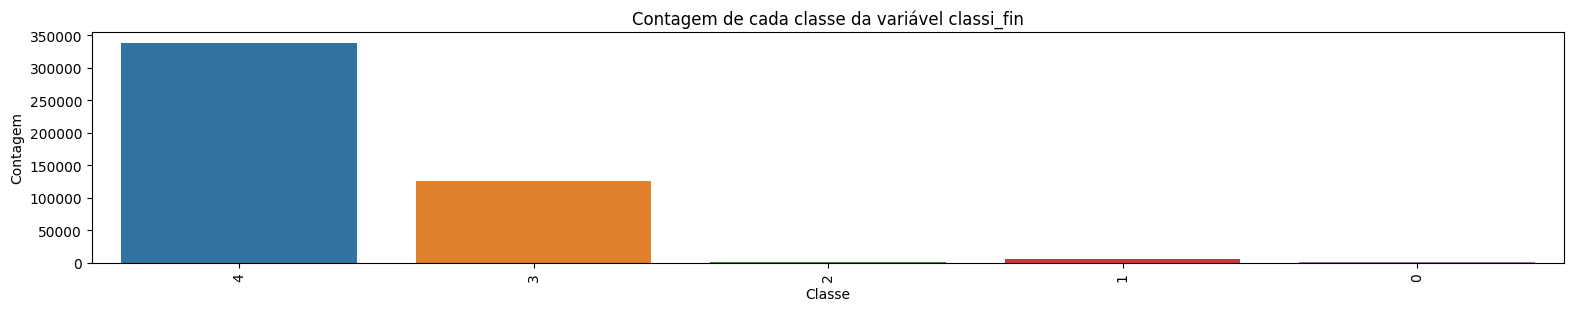

In [51]:
# Calculando os percentuais de cada classe
percentuais = df4['classi_fin'].value_counts(normalize = True)

# Definindo as cores
cores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Reordenando os percentuais para que a classe com maior frequência fique à esquerda
percentuais = percentuais.sort_index(ascending = False)

# Criando o gráfico de barras empilhadas
plt.figure(figsize = (19, 3))
sns.countplot(x = 'classi_fin', data = df4, order = percentuais.index, palette = cores)

# Adicionando rótulos e título
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.title('Contagem de cada classe da variável classi_fin')

plt.xticks(rotation = 90)
# Exibir o gráfico
plt.show();

* Há um desbalanceamento nas classes da variável resposta, com as classes 3 e 4 apresentando um número significativamente maior de observações em comparação com as demais classes.

In [52]:
# Definir as colunas que você deseja plotar
#colunas = ['idade_anos', 'cs_gestant', 'cs_raca', 'cs_escol_n', 'cs_zona', 'nosocomial', 'ave_suino', 'febre', 'tosse', 'garganta', 'dispneia',
#           'desc_resp', 'saturacao', 'diarreia', 'vomito', 'puerpera', 'cardiopati', 'hematologi', 'sind_down', 'hepatica', 'asma',
#           'diabetes', 'neurologic', 'pneumopati', 'imunodepre', 'renal', 'obesidade', 'vacina', 'antiviral', 'tp_antivir', 'hospital',
#           'uti', 'suport_ven', 'raiox_res', 'tp_amostra', 'dor_abd', 'fadiga', 'perd_olft', 'perd_pala', 'tomo_res', 'vacina_cov',
#           'dose_1_cov', 'dose_2_cov', 'dose_ref']
#
## Ajustar o tamanho da grade para acomodar todas as colunas
#num_colunas = 6
#num_linhas = (len(colunas) + num_colunas - 1) // num_colunas  # Calcula o número necessário de linhas
#plt.figure(figsize = (20, num_linhas * 2))  # Ajusta a altura com base no número de linhas
#
## Concatenar os gráficos
#grid = GridSpec(num_linhas, num_colunas)
#
## Iterar sobre as colunas e plotar os histogramas
#for i, coluna in enumerate(colunas):
#    plt.subplot(grid[i // num_colunas, i % num_colunas])
#    sns.histplot(x = coluna, data = df4, linewidth = 1)
#    plt.title(coluna)
#
#plt.tight_layout()
#plt.show();

* É possivel observar que as variáveis não possuem distribuição normal

In [53]:
## Número de colunas para os subplots
#n_cols = 6
#n_rows = int(np.ceil(len(colunas) / n_cols))
#
#fig, axs = plt.subplots(n_rows, n_cols, figsize = (24, 2 * n_rows))
#
#for i, coluna in enumerate(colunas):
#    row = i // n_cols
#    col = i % n_cols
#    ax = axs[row, col]
#    ax.set_title(f'Q-Q Plot for {coluna}')
#    sm.qqplot(df4[coluna], line = 's', ax = ax)
#
## Remover subplots vazios
#for i in range(len(colunas), n_rows * n_cols):
#    fig.delaxes(axs.flatten()[i])
#
#plt.tight_layout()
#plt.show();

* O Q-Q Plot (Quantile-Quantile Plot) é uma técnica visual utilizada para verificar se uma distribuição de dados está próxima de uma distribuição normal. Ele compara os quantis (percentis) dos dados observados com os quantis esperados de uma distribuição normal teórica. Ou seja, se os dados estiverem em sua maioria na linha vermelha, os dados apresentam uma distriuição Gausiana, isso pode ser um indicativo de que os dados precisarão passar por alguma transformação para melhor se adequar a uma distribuição normal.

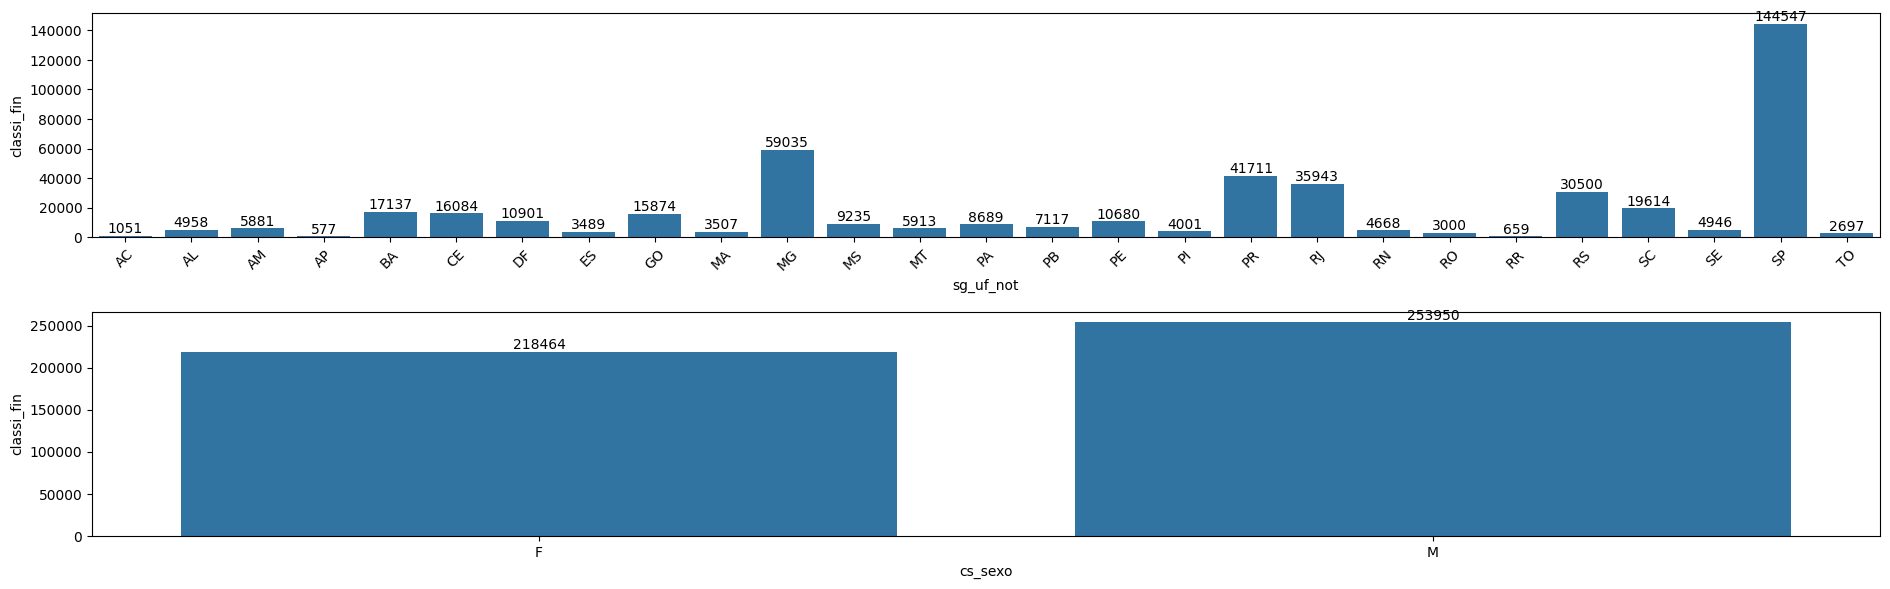

In [54]:
plt.figure(figsize = (19, 6)) # Ajusta a altura com base no número de linhas

# Concatenar os gráficos
grid = GridSpec(2, 1) # GridSpec(linha, coluna)
# Linha especifica o nº de linhas na grade, Neste caso, 1 o que significa que teremos apenas uma linha na grade.
# Coluna especifica o nº de colunas na grade. Neste caso, 3 o que significa que teremos três colunas na grade.

plt.subplot(grid[0, 0]) # [0, 0] refere-se à primeira linha e primeira coluna da grade.
aux1 = df4[['sg_uf_not', 'classi_fin']].groupby(['sg_uf_not']).count().reset_index()
sns.barplot(x = 'sg_uf_not', y = 'classi_fin', data = aux1)
for index, value in enumerate(aux1['classi_fin']):
    plt.text(index, value, str(value), ha = 'center', va = 'bottom')  # Adiciona os valores aos gráficos de barras
plt.xticks(rotation = 45)

plt.subplot(grid[1, 0]) # [0, 0] refere-se à primeira linha e primeira coluna da grade.
aux2 = df4[['cs_sexo', 'classi_fin']].groupby(['cs_sexo']).count().reset_index()
sns.barplot(x = 'cs_sexo', y = 'classi_fin', data = aux2)
for index, value in enumerate(aux2['classi_fin']):
    plt.text(index, value, str(value), ha = 'center', va = 'bottom')  # Adiciona os valores aos gráficos de barras

plt.tight_layout();
plt.show();

### 4.2 Análise bivariada

**1** Pessoas que não tomaram vacina tem maior nº de casos de covid?

**Verdadeira** Pessoas que não tomaram vacina tem sim maior nº de casos de covid.

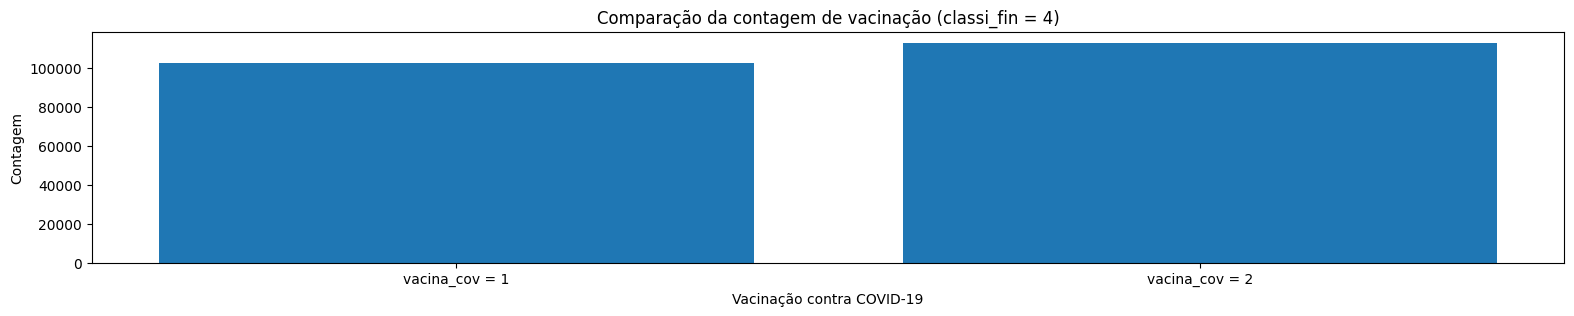

In [55]:
# Variável 'vacina_cov' igual a 1
aux1 = df4.loc[(df4['vacina_cov'] == 1) & (df4['classi_fin'] == 4), ['vacina_cov', 'classi_fin']]
aux1.groupby('vacina_cov').count().reset_index()

# Variável 'vacina_cov' igual a 2
aux2 = df4.loc[(df4['vacina_cov'] == 2) & (df4['classi_fin'] == 4), ['vacina_cov', 'classi_fin']]
aux2.groupby('vacina_cov').count().reset_index()

# Dados
labels = ['vacina_cov = 1', 'vacina_cov = 2']
valores = [aux1.shape[0], aux2.shape[0]]

# Criando gráfico de barras
plt.figure(figsize = (19, 3))
plt.bar(labels, valores)

# Adicionando rótulos e título
plt.xlabel('Vacinação contra COVID-19')
plt.ylabel('Contagem')
plt.title('Comparação da contagem de vacinação (classi_fin = 4)')

# Exibindo o gráfico
plt.show();

**2** Pessoas que estão em área urbana a tendência de contrair covid é maior?

**Verdadeira** Pessoas que estão em área urbana a tendência de contrair covid é expressivamente maior.

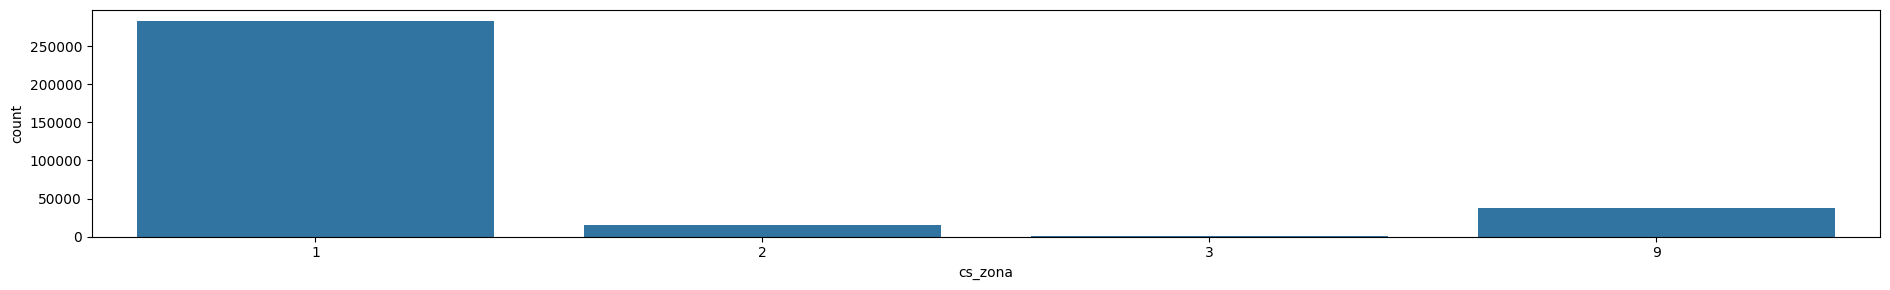

In [56]:
plt.figure(figsize = (19, 3)) #Ajuste o tamanho conforme necessário

aux1 = df4.loc[df4['classi_fin'] == 4, ['cs_zona', 'classi_fin']]
aux1.groupby('cs_zona').count().reset_index()
sns.countplot(x = 'cs_zona', data = aux1)

plt.tight_layout();

**3** Pessoas que tem contato com animais do tipo ave ou suino tem mais chance de contrair covid?

**Verdadeira** Pessoas que tem contato com animais do tipo ave ou suino tem sim mais chance de contrair covid.

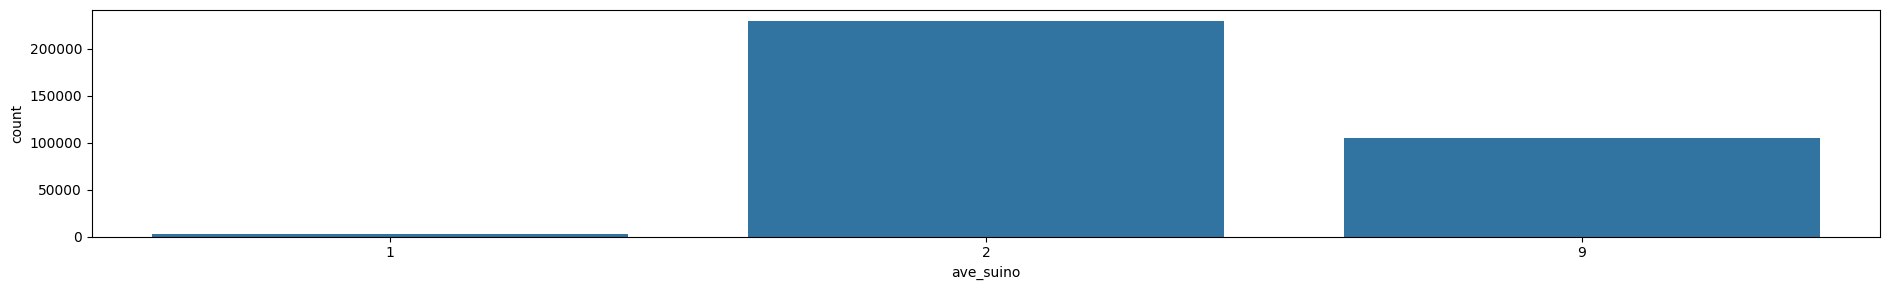

In [57]:
plt.figure(figsize = (19, 3)) #Ajuste o tamanho conforme necessário

aux1 = df4.loc[df4['classi_fin'] == 4, ['ave_suino', 'classi_fin']]
aux1.groupby('ave_suino').count().reset_index()
sns.countplot(x = 'ave_suino', data = aux1)

plt.tight_layout();

**4** Pessoas que vivem no interior de Santa Catarina não teriam tendência a contrair covid?

**Falsa** Pessoas que vivem no interior de Santa Catarina teriam sim maior tendência a contrair covid.

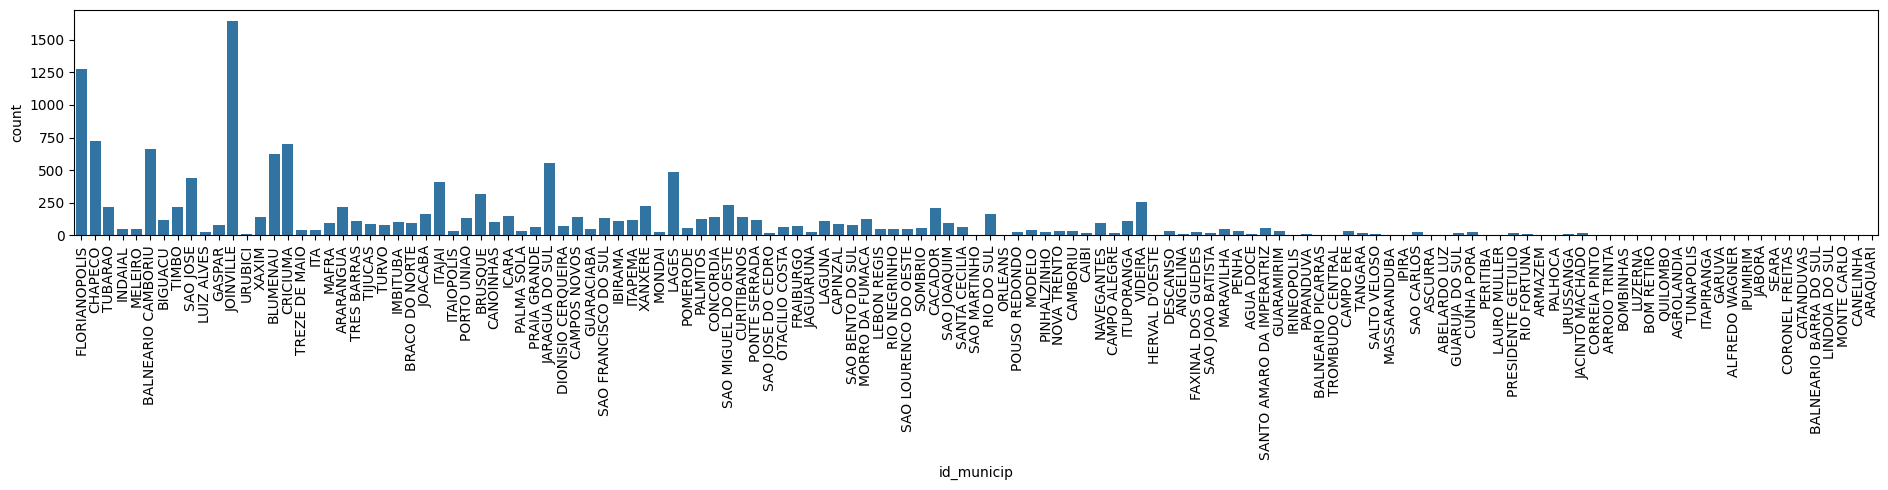

In [58]:
plt.figure(figsize = (19, 5))

# Variável 'sg_uf_not' igual a SC
aux1 = df4.loc[(df4['sg_uf_not'] == 'SC') & (df4['classi_fin'] == 4), ['sg_uf_not', 'id_municip', 'classi_fin']]
aux1.groupby(['sg_uf_not', 'id_municip']).count().reset_index()  # Resetando o índice após a operação de agrupamento
sns.countplot(x = 'id_municip', data = aux1)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show();

**5** Pessoas com mais idade tem tendência a contrair covid?

**Verdadeira** Pessoas com mais idade tem sim maior tendência a contrair covid.

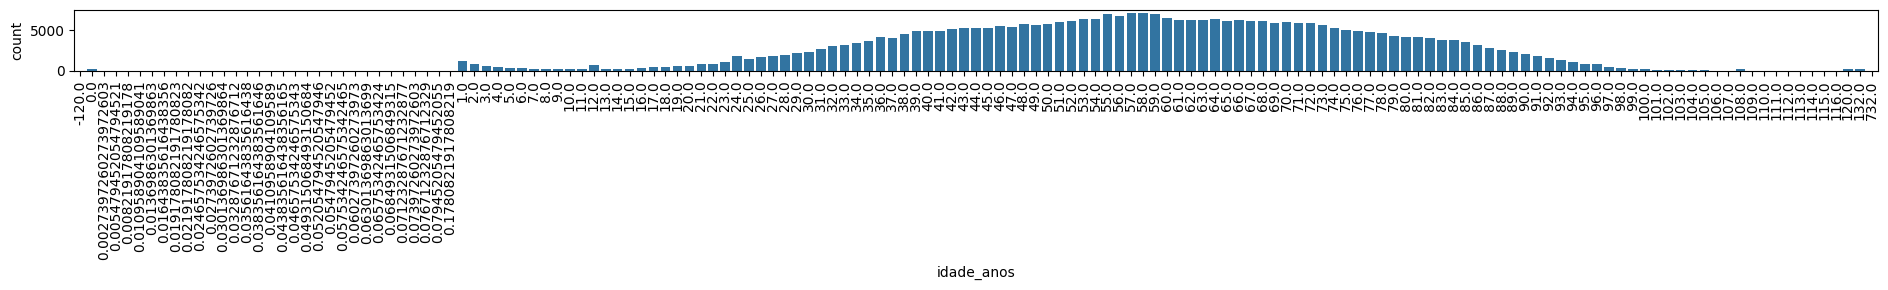

In [59]:
plt.figure(figsize = (19, 3))

aux = df4.loc[df4['classi_fin'] == 4, ['idade_anos']]
aux.groupby('idade_anos').count().reset_index()
sns.countplot(x = 'idade_anos', data = aux)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show();

**6** Cidades da região sul tem maior tendência a contrair doenças respiratórias?

**Falsa** Cidades da região sul não tem maior tendência a contrair doenças respiratórias e sim a região sudeste.

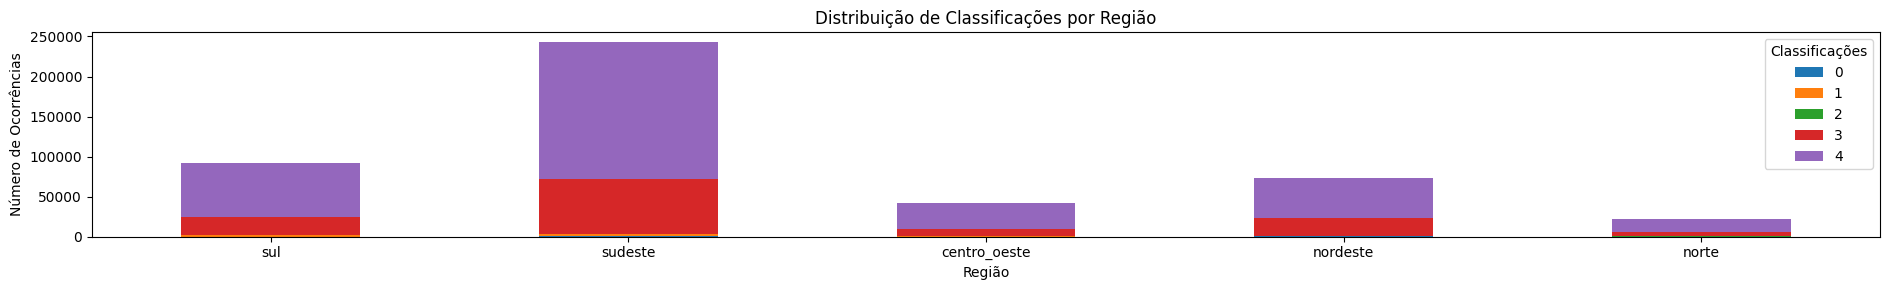

In [60]:
# Filtrando os dados para cada regiõa
sul = df4[df4['sg_uf_not'].isin(['PR', 'SC', 'RS'])]
sudeste = df4[df4['sg_uf_not'].isin(['ES', 'MG', 'RJ', 'SP'])]
centro_oeste = df4[df4['sg_uf_not'].isin(['GO', 'MT', 'MS', 'DF'])]
nordeste = df4[df4['sg_uf_not'].isin(['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'])]
norte = df4[df4['sg_uf_not'].isin(['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'])]

# Contando as ocorrências de 'classi_fin' em cada região
aux_sul = sul['classi_fin'].value_counts()
aux_sudeste = sudeste['classi_fin'].value_counts()
aux_centro_oeste = centro_oeste['classi_fin'].value_counts()
aux_nordeste = nordeste['classi_fin'].value_counts()
aux_norte = norte['classi_fin'].value_counts()

aux = pd.DataFrame({'sul': aux_sul, 
                    'sudeste': aux_sudeste, 
                    'centro_oeste': aux_centro_oeste, 
                    'nordeste': aux_nordeste, 
                    'norte': aux_norte}).reset_index()

# Renomeando a coluna 'index' para 'classi_fin'
aux = aux.rename(columns = {'index': 'classi_fin'})

# Criando o gráfico de barras empilhadas
ax = aux.set_index('classi_fin').T.plot(kind = 'bar', stacked = True, figsize = (19, 3))

# Adicionando títulos e rótulos
ax.set_title('Distribuição de Classificações por Região')
ax.set_xlabel('Região')
ax.set_ylabel('Número de Ocorrências')
ax.legend(title = 'Classificações')
plt.xticks(rotation = 0)
plt.tight_layout()

# Exibindo o gráfico
plt.show();

**7** Pessoas que tomaram antiviral tiveram menos sintomas graves?

**Falsa** Pessoas que não tomaram antiviral tiveram mais sintomas graves.

In [61]:
df_filtrado = df4.copy()

# Filtrando o DataFrame
df_filtrado_1 = df_filtrado.loc[df_filtrado['antiviral'] == 1, ['febre', 'tosse', 'garganta', 'dispneia', 'desc_resp', 'saturacao', 'diarreia', 'vomito']]
df_filtrado_2 = df_filtrado.loc[df_filtrado['antiviral'] == 2, ['febre', 'tosse', 'garganta', 'dispneia', 'desc_resp', 'saturacao', 'diarreia', 'vomito']]

# Criando uma nova coluna que soma apenas os valores iguais a 1 nas colunas de sintomas
df_filtrado_1['total_sintomas'] = (df_filtrado_1 == 1).sum(axis = 1)
df_filtrado_2['total_sintomas'] = (df_filtrado_2 == 1).sum(axis = 1)

aux = pd.DataFrame({'Sim': [df_filtrado_1['total_sintomas'].sum()], 
                    'Não': [df_filtrado_2['total_sintomas'].sum()]}, 
                    index = ['Tomou antiviral?'])

aux

,Sim,Não
Tomou antiviral?,51786,1108876


### 4.3 Análise multivariada

In [62]:
# Fazendo a correlação de todas as variáveis com a variável resposta
correlacao_continua = df4.select_dtypes(include = 'number').corr()['classi_fin']

# Separar correlações positivas e negativas
correlacao_positiva = correlacao_continua[correlacao_continua > 0].sort_values(ascending = False)
correlacao_negativa = correlacao_continua[correlacao_continua < 0].sort_values()

# Garantir que ambas as listas tenham o mesmo comprimento preenchendo com NaN
max_length = max(len(correlacao_positiva), len(correlacao_negativa))

positiva_index = list(correlacao_positiva.index) + [None] * (max_length - len(correlacao_positiva))
positiva_values = list(correlacao_positiva.values) + [None] * (max_length - len(correlacao_positiva))
negativa_index = list(correlacao_negativa.index) + [None] * (max_length - len(correlacao_negativa))
negativa_values = list(correlacao_negativa.values) + [None] * (max_length - len(correlacao_negativa))

# Criar o DataFrame final
Correlacao = pd.DataFrame({
    'Variável Positiva': positiva_index,
    'Correlação Positiva': positiva_values, 
    'Variável Negativa': negativa_index,                           
    'Correlação Negativa': negativa_values})

Correlacao

,Variável Positiva,Correlação Positiva,Variável Negativa,Correlação Negativa
0,classi_fin,1.000000,tomo_res,-0.214858
1,idade_anos,0.176343,dose_2_cov,-0.072724
2,vacina_cov,0.126352,cardiopati,-0.072236
3,raiox_res,0.095946,diabetes,-0.066808
4,antiviral,0.039054,suport_ven,-0.062755
5,tp_amostra,0.027715,vacina,-0.058755
6,vomito,0.021090,obesidade,-0.058047
7,ave_suino,0.020195,uti,-0.049789
8,cs_zona,0.012033,dose_1_cov,-0.046987
9,tosse,0.011128,dose_ref,-0.045687


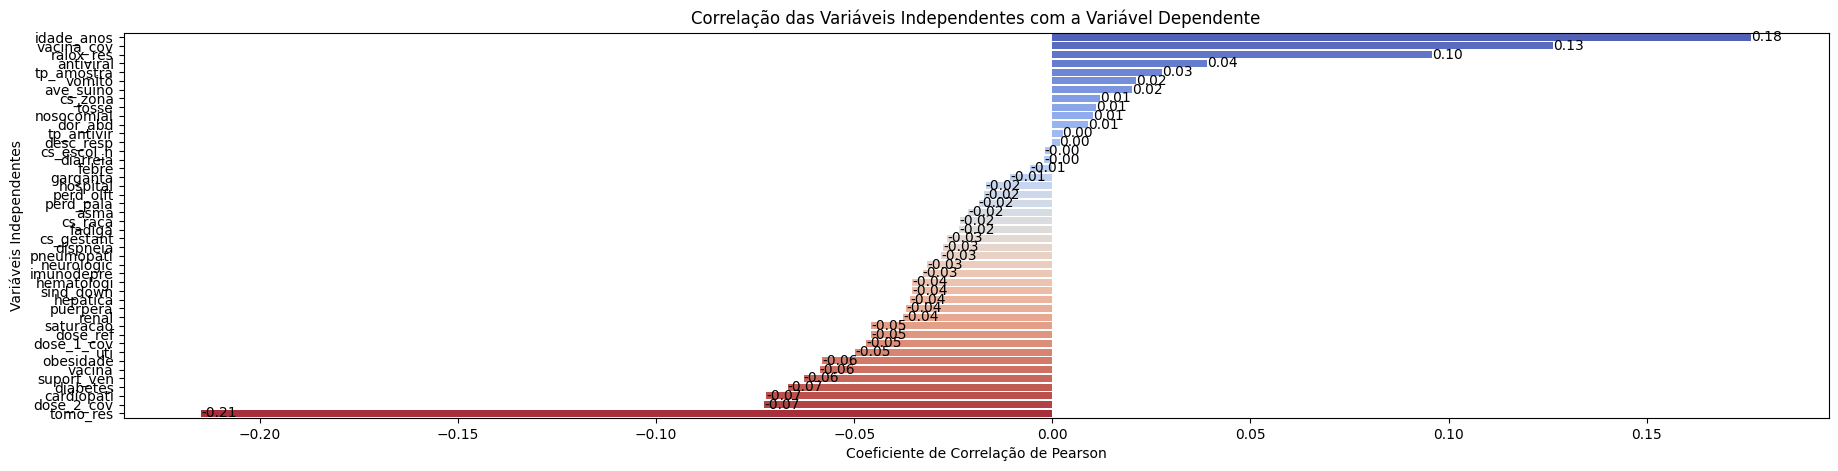

In [63]:
# Criando um DataFrame
correlacoes_ = df4.select_dtypes(include = 'number')

# Calculando as correlações de Pearson entre todas as variáveis
correlacoes = correlacoes_.corr()

# Selecionndo a correlação da variável dependente com todas as outras variáveis
# Supondondo que a variável dependente esteja na última coluna
corr_com_y = correlacoes.iloc[:-1, -1]  # Todas as variáveis com a última variável (variável resposta)

# Organizndo as correlações em ordem decrescente
corr_com_y = corr_com_y.sort_values(ascending = False)

# Plotando as correlações
plt.figure(figsize = (22, 5))
sns.barplot(x = corr_com_y.values, y = corr_com_y.index, palette = 'coolwarm')

# Adicionando os valores das correlações no gráfico
for i, v in enumerate(corr_com_y):
    plt.text(v, i, f"{v:.2f}", color = 'black', ha = 'left', va = 'center')

plt.title('Correlação das Variáveis Independentes com a Variável Dependente')
plt.xlabel('Coeficiente de Correlação de Pearson')
plt.ylabel('Variáveis Independentes')
plt.show();

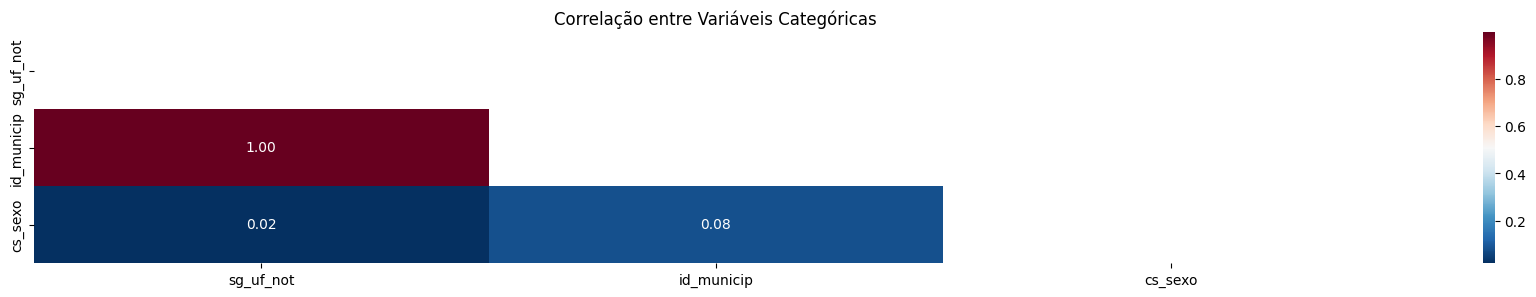

In [64]:
# Fazendo a correlação de todas as variáveis com a variável resposta
correlacao_categorica = df4.select_dtypes(exclude = 'number')

a1 = cramer_v(correlacao_categorica['sg_uf_not'], correlacao_categorica['sg_uf_not'])
a2 = cramer_v(correlacao_categorica['sg_uf_not'], correlacao_categorica['id_municip'])
a3 = cramer_v(correlacao_categorica['sg_uf_not'], correlacao_categorica['cs_sexo'])

a4 = cramer_v(correlacao_categorica['id_municip'], correlacao_categorica['sg_uf_not'])
a5 = cramer_v(correlacao_categorica['id_municip'], correlacao_categorica['id_municip'])
a6 = cramer_v(correlacao_categorica['id_municip'], correlacao_categorica['cs_sexo'])

a7 = cramer_v(correlacao_categorica['cs_sexo'], correlacao_categorica['sg_uf_not'])
a8 = cramer_v(correlacao_categorica['cs_sexo'], correlacao_categorica['id_municip'])
a9 = cramer_v(correlacao_categorica['cs_sexo'], correlacao_categorica['cs_sexo'])

pd.DataFrame({'sg_uf_not': [a1, a2, a3],
              'id_municip': [a4, a5, a6],
              'cs_sexo': [a7, a8, a9]})

d = pd.DataFrame({'sg_uf_not': [a1, a2, a3],
                  'id_municip': [a4, a5, a6],
                  'cs_sexo': [a7, a8, a9]})
d = d.set_index(d.columns) #Inserindo os nomes das linhas iguais aos nomes das colunas

# Aplicando a máscara triangular
mask = np.triu(np.ones_like(d, dtype = bool))

# Plotando o heatmap
plt.figure(figsize = (22, 3))
sns.heatmap(d, annot = True, mask = mask, cmap = 'RdBu_r', fmt = ".2f")
plt.title('Correlação entre Variáveis Categóricas')
plt.show();

* As variáveis 'id_municip' e 'sg_uf_not' possuem uma alta multicolinearidade, então optou-se em retirar a variável 'id_municip'

# 5. (Modelagem dos dados) Passo 5: Preparação dos dados

In [65]:
df5 = df4.drop(['id_municip'], axis = 1).copy()

### 5.1 Separar os dados em treino e teste

* Devido ao dataset ter classes desbalanceadas é necessário utilizar um parâmetro no train_test_split chamado de stratify = y, onde este parâmetro mantém a distribuição das classes ou características em ambas as partes. 

* <font color = 'yellow'>Obs.: Devido o data set ter muitas linhas, optou-se fazer uma amostragem com a mesmas a quantidade de dados para cada classe.</font> 

In [66]:
df5['classi_fin'].value_counts()

classi_fin
4    337990
3    125149
1      6236
0      1585
2      1454
Name: count, dtype: int64

In [67]:
class1 = df5[df5['classi_fin'] == 0]
class2 = df5[df5['classi_fin'] == 1]
class3 = df5[df5['classi_fin'] == 2]
class4 = df5[df5['classi_fin'] == 3].sample(5000)
class5 = df5[df5['classi_fin'] == 4].sample(5000)

In [68]:
df_classificado = pd.concat([class1, class2, class3, class4, class5], ignore_index = True)

In [69]:
df_classificado['classi_fin'].value_counts().sort_index(ascending = True)

classi_fin
0    1585
1    6236
2    1454
3    5000
4    5000
Name: count, dtype: int64

In [70]:
x = df_classificado.drop('classi_fin', axis = 1)
y = df_classificado['classi_fin'].copy()

x_treino, x_teste, y_treino, y_teste = ms.train_test_split(x, y, test_size = 0.2, stratify = y)

df5 = pd.concat([x_treino, y_treino], axis = 1)

In [71]:
print('x_treino: {}'.format(x_treino.shape))
print('x_teste: {}'.format(x_teste.shape))
print('y_treino: {}'.format(y_treino.shape))
print('y_teste: {}'.format(y_teste.shape))

x_treino: (15420, 46)
x_teste: (3855, 46)
y_treino: (15420,)
y_teste: (3855,)


### 5.2 Transformar os dados

* REGRAS PARA ESCOLHA DO TIPO DE TRANSFORMAÇÃO DE ESCALA:

* 1. Distribuição normal e não possui outliers - > <font color = 'yellow'>Padronização (StandardScaler)</font>
    - Este tipo de transformação de variáveis são indicadas para distribuições normais
    - Verificar na análise univariada quais variáveis tem esta caracteristica de distribuição normal
    - Média: 0 e desvio padrão: 1

* 2. Distribuição não normal e não possui outliers - > <font color = 'yellow'>Normalização (MinMaxScaler)</font>
    - Este tipo de transformação de variáveis são indicadas para distribuições não normais
    - Dados entre 0 e 1

* 3. Distribuição normal e não normal e possui outliers - > <font color = 'yellow'>Normalização (RobustScaler)</font>
    - Quartis

#### 5.2.1 Variável numérica

##### <s>5.2.1.1 Padronização</s>

##### 5.2.1.2 Normalização

##### 5.2.1.3 Dados de treino

In [72]:
# Listando das colunas a serem transformadas com MinMax Scaler
colunas_para_transformar = ['cs_gestant', 'cs_raca', 'cs_escol_n', 'cs_zona', 'nosocomial', 'ave_suino', 
                            'febre', 'tosse', 'garganta', 'dispneia', 'desc_resp', 'saturacao', 'diarreia', 
                            'vomito', 'puerpera', 'cardiopati', 'hematologi', 'sind_down', 'hepatica', 
                            'asma', 'diabetes', 'neurologic', 'pneumopati', 'imunodepre', 'renal', 
                            'obesidade', 'vacina', 'antiviral', 'tp_antivir', 'hospital', 'uti', 'suport_ven',
                            'raiox_res', 'tp_amostra', 'dor_abd', 'fadiga', 'perd_olft', 'perd_pala',
                            'tomo_res', 'vacina_cov', 'dose_1_cov', 'dose_2_cov', 'dose_ref', 'idade_anos']

# Aplicando MinMaxScaler para todas as colunas e salvando os dados transformados em arquivos pickle
for column in colunas_para_transformar:
    scaler = pp.MinMaxScaler()
    df5[[column]] = scaler.fit_transform(df5[[column]].values)
    pickle_name = f'{column}_scaler.pkl'
    pickle_path = os.path.join('/home/leonardo/projetos_/formulario_medico/transformacoes', pickle_name)
    with open(pickle_path, 'wb') as f:
        pickle.dump(scaler, f)

##### 5.2.1.4 Dados de teste

In [73]:
# Carregando as instâncias transformadas salvas em arquivos pickle
instancias_transformadas = {}
for column in colunas_para_transformar:
    pickle_path = f'/home/leonardo/projetos_/formulario_medico/transformacoes/{column}_scaler.pkl'
    with open(pickle_path, 'rb') as f:
        instancias_transformadas[column] = pickle.load(f)

# Aplicando as transformações aos dados de teste
for column in colunas_para_transformar:
    transformer = instancias_transformadas[column]
    x_teste[column] = transformer.transform(x_teste[[column]].values)

#### 5.2.2 Variável categórica

##### 5.2.2.1 Encoding

* Optou-se por aplicar o label encoding nas variáveis categóricas.

##### 5.2.2.2 Dados de treino

In [74]:
# Listando das colunas a serem encodadas com LabelEncoder
colunas_para_encodar = ['sg_uf_not', 'cs_sexo']

# Aplicando LabelEncoder para todas as colunas e salvando os dados encodados em arquivos pickle
for column in colunas_para_encodar:
    encoder = le()
    df5[column] = encoder.fit_transform(df5[[column]].values)
    pickle_name = f'{column}_encoder.pkl'
    pickle_path = os.path.join('/home/leonardo/projetos_/formulario_medico/transformacoes', pickle_name)
    with open(pickle_path, 'wb') as f:
        pickle.dump(encoder, f)

##### 5.2.2.3 Dados de teste

In [75]:
# Carregando as instâncias encodadas salvas em arquivos pickle
instancias_encodadas = {}
for column in colunas_para_encodar:
    pickle_path = f'/home/leonardo/projetos_/formulario_medico/transformacoes/{column}_encoder.pkl'
    with open(pickle_path, 'rb') as f:
        instancias_encodadas[column] = pickle.load(f)

# Aplicando as transformações aos dados de teste
for column in colunas_para_encodar:
    encoder = instancias_encodadas[column]
    x_teste[column] = encoder.transform(x_teste[[column]].values)

# 6. (Modelagem dos dados) Passo 6: Seleção das variáveis

In [76]:
df6 = df5.copy().reset_index(drop = True)

### 6.1 Identificar as variáveis mais relevantes

#### 6.1.1 Importância das árvores

Rank das importâncias:
     Variável  Importância
0  idade_anos     0.083772
0    tomo_res     0.077049
0   sg_uf_not     0.055090
0   raiox_res     0.041251
0  cs_escol_n     0.039596
0     cs_raca     0.037127
0  suport_ven     0.036389
0  vacina_cov     0.032896
0         uti     0.031224
0  cs_gestant     0.028975
0       febre     0.028494
0   desc_resp     0.026346
0   saturacao     0.026186
0    dispneia     0.026084
0       tosse     0.025799
0      vacina     0.025402
0     cs_sexo     0.024406
0   antiviral     0.022534
0     cs_zona     0.021481
0  cardiopati     0.020822
0      fadiga     0.019660
0    garganta     0.019303
0    diabetes     0.018745
0   ave_suino     0.018411
0  tp_antivir     0.017322
0  nosocomial     0.016420
0      vomito     0.015992
0  tp_amostra     0.015076
0    diarreia     0.014584
0  dose_2_cov     0.014286
0  dose_1_cov     0.012587
0     dor_abd     0.011327
0   perd_pala     0.009334
0  pneumopati     0.009121
0   obesidade     0.009082
0    

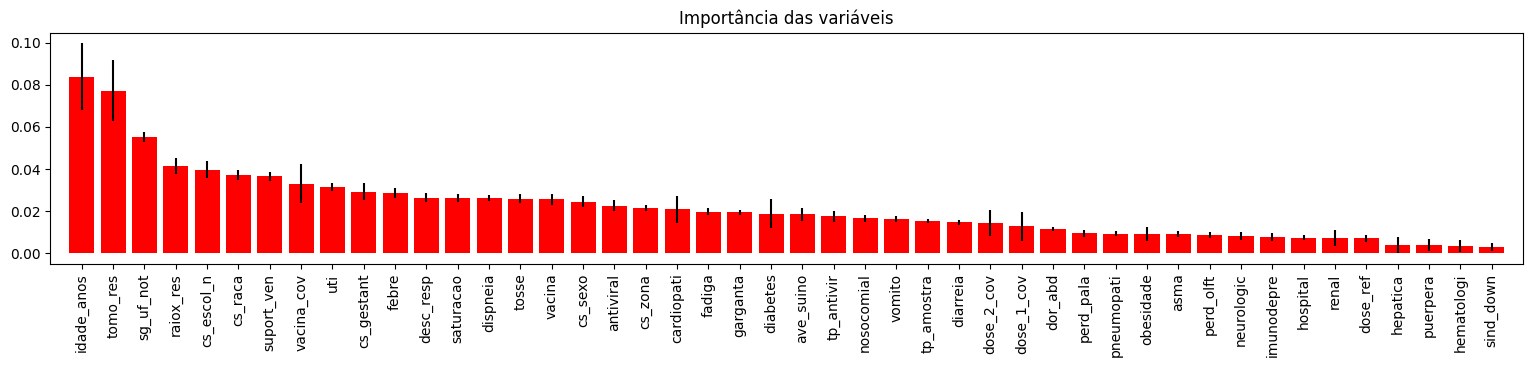

In [77]:
#Definição do modelo
forest = ExtraTreesClassifier(n_estimators = 50, random_state = 0, n_jobs = -1)

#Preparação dos dados
x_treino_n = df6.drop(['classi_fin'], axis = 1)
y_treino_n = df6['classi_fin']
forest.fit(x_treino_n, y_treino_n)

importancias = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importancias)[::-1]

#Imprimindo o rank das importâncias
print('Rank das importâncias:')
df = pd.DataFrame()
for i, j in zip(x_treino_n, forest.feature_importances_):
    aux = pd.DataFrame({'Variável': i, 'Importância': j}, index = [0])
    df = pd.concat([df, aux], axis = 0)

print(df.sort_values('Importância', ascending = False))

#Plotando a impureza baseando-se na importância das variáveis
plt.figure(figsize = (19, 3))
plt.title('Importância das variáveis')
plt.bar(range(x_treino_n.shape[1]), importancias[indices], color = 'r', yerr = std[indices], align = 'center')
plt.xticks(range(x_treino_n.shape[1]), x_treino_n.columns[indices], rotation = 90)
plt.xlim([-1, x_treino_n.shape[1]])
plt.show();

* A importância das árvores serve para analisar e visualizar a relevância das variáveis preditoras em um modelo de floresta aleatória. O atributo feature_importances_ é usado em modelos de árvores de decisão e florestas aleatórias para fornecer uma medida da importância de cada variável preditora no modelo. Esse atributo atribui uma pontuação de importância para cada variável com base em sua contribuição para reduzir a impureza nos nós da árvore durante o treinamento do modelo. Neste caso, as variáveis 'age' e 'cement' possuem maior relevância em relação as outras variáveis. 

### 6.2 Selecionar as melhores variáveis

In [108]:
colunas_selecionadas = ['idade_anos', 'tomo_res', 'sg_uf_not',
                        'raiox_res', 'cs_escol_n', 'suport_ven',
                        'cs_raca', 'vacina_cov', 'antiviral', 'asma', 
                        'dose_2_cov', 'dose_ref', 'tp_antivir',
                        'vacina', 'dose_1_cov', 'tp_amostra']

# 7. (Algoritmos de Ml) Passo 7: Implementar os modelos de machine learning

In [109]:
x_treino = df6[colunas_selecionadas].reset_index(drop = True)
y_treino = df6['classi_fin'].reset_index(drop = True)

In [111]:
x_teste = x_teste[colunas_selecionadas]

In [112]:
x_treino.head(3)

,idade_anos,tomo_res,sg_uf_not,raiox_res,cs_escol_n,suport_ven,cs_raca,vacina_cov,antiviral,asma,dose_2_cov,dose_ref,tp_antivir,vacina,dose_1_cov,tp_amostra
0,0.303030,0.625,25,1.0,0.111111,0.125,0.125,0.125,0.125,1.0,0.0,0.0,0.0,0.125,0.0,0.000
1,0.272727,0.625,17,0.5,1.000000,0.125,0.000,0.125,0.125,1.0,0.0,0.0,0.0,1.000,0.0,0.375
2,0.818182,1.000,17,1.0,1.000000,0.125,1.000,1.000,0.125,1.0,0.0,0.0,0.0,0.125,0.0,0.000


### 7.1 Algoritmo Media (Baseline)

In [113]:
# Encontrando a classe com o menor número de amostras
min_samples = min([len(y_treino[y_treino == classe]) for classe in np.unique(y_treino)])

# Amostragem aleatória de igual número de amostras de cada classe
amostras_balanceadas = []
for classe in np.unique(y_treino):
    amostras_classe = x_treino[y_treino == classe]
    amostras_balanceadas.append(resample(amostras_classe, replace=False, n_samples = min_samples, random_state = 42))

X_balanceado = np.concatenate(amostras_balanceadas)
y_balanceado = np.concatenate([np.full(min_samples, classe) for classe in np.unique(y_treino)])

# Calculando a média das classes balanceadas
media_classes_balanceadas = np.mean(y_balanceado)
y_pred_baseline_balanceado = np.full_like(y_teste, fill_value=media_classes_balanceadas)

# Acurácia
acuracia_baseline_balanceado = accuracy_score(y_teste, y_pred_baseline_balanceado)

# Precisão
precisao_baseline_balanceado = precision_score(y_teste, y_pred_baseline_balanceado, average = 'weighted')

# Recall
recall_baseline_balanceado = recall_score(y_teste, y_pred_baseline_balanceado, average = 'weighted')

# AUC
# Calculando o AUC como a área sob a curva ROC de um modelo perfeitamente aleatório
# A curva ROC seria uma linha diagonal, então o AUC será a área sob essa linha
# Isso é conhecido como AUC do modelo nulo ou AUC aleatório
auc_baseline_balanceado = 0.5  # Área sob a linha diagonal da curva ROC

# Salvando em um DataFrame
df_baseline_balanceado = pd.DataFrame({'algoritmo': ['Média das classes'],
                                       'acuracia': [f'{acuracia_baseline_balanceado*100:.2f}%'],
                                       'precision': [f'{precisao_baseline_balanceado*100:.2f}%'],
                                       'recall': [f'{recall_baseline_balanceado*100:.2f}%'],
                                       'auc': [f'{auc_baseline_balanceado:.2f}']})

df_baseline_balanceado

,algoritmo,acuracia,precision,recall,auc
0,Média das classes,7.55%,0.57%,7.55%,0.50


### 7.2 Algoritmo KNN

In [114]:
# Definindo o modelo
knn_modelo = nh.KNeighborsClassifier(n_neighbors = 9)

# Treinando o modelo com cross validation
validacao_cruzada(knn_modelo, x_treino, y_treino, desbalanceado = True)

# Obtendo o nome do modelo
nome_modelo = type(knn_modelo).__name__

# Obtendo a previsão
y_pred_knn = pd.read_csv("resultados_" + nome_modelo + ".csv")

Tamanho das classes não balanceadas:
classi_fin
1    4989
3    4000
4    4000
0    1268
2    1163
Name: count, dtype: int64

Tamanho das classes balanceadas:
classi_fin
2    4012
1    4012
0    4012
3    4012
4    4012
Name: count, dtype: int64

Acuracia: 44.72%
Precisao: 50.98%
Recall: 44.72%
AUC: 0.73


### 7.3 Algoritmo Regressão Logística

In [115]:
# Definindo o modelo
lr_modelo = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C = 1.0, max_iter = 100)

# Treinando o modelo com cross validation
validacao_cruzada(lr_modelo, x_treino, y_treino, desbalanceado = True)

# Obtendo o nome do modelo
nome_modelo = type(lr_modelo).__name__

# Obtendo a previsão
y_pred_lr = pd.read_csv("resultados_" + nome_modelo + ".csv")

Tamanho das classes não balanceadas:
classi_fin
1    4989
3    4000
4    4000
0    1268
2    1163
Name: count, dtype: int64

Tamanho das classes balanceadas:
classi_fin
2    4012
1    4012
0    4012
3    4012
4    4012
Name: count, dtype: int64

Acuracia: 43.61%
Precisao: 46.06%
Recall: 43.61%
AUC: 0.73


### 7.4 Algoritmo Naive Bayes

In [116]:
# Definindo o modelo
nb_modelo = GaussianNB()

# Treinando o modelo com cross validation
validacao_cruzada(nb_modelo, x_treino, y_treino, desbalanceado = True)

# Obtendo o nome do modelo
nome_modelo = type(nb_modelo).__name__

# Obtendo a previsão
y_pred_nb = pd.read_csv("resultados_" + nome_modelo + ".csv")

Tamanho das classes não balanceadas:
classi_fin
1    4989
3    4000
4    4000
0    1268
2    1163
Name: count, dtype: int64

Tamanho das classes balanceadas:
classi_fin
2    4012
1    4012
0    4012
3    4012
4    4012
Name: count, dtype: int64

Acuracia: 44.84%
Precisao: 45.76%
Recall: 44.84%
AUC: 0.73


### 7.5 Algoritmo Random Forest

In [117]:
# Definindo o modelo
rf_modelo = RandomForestClassifier(n_estimators = 20, random_state = 42)

# Treinando o modelo com cross validation
validacao_cruzada(rf_modelo, x_treino, y_treino, desbalanceado = True)

# Obtendo o nome do modelo
nome_modelo = type(rf_modelo).__name__

# Obtendo a previsão
y_pred_rf = pd.read_csv("resultados_" + nome_modelo + ".csv")

Tamanho das classes não balanceadas:
classi_fin
1    4989
3    4000
4    4000
0    1268
2    1163
Name: count, dtype: int64

Tamanho das classes balanceadas:
classi_fin
2    4012
1    4012
0    4012
3    4012
4    4012
Name: count, dtype: int64

Acuracia: 56.21%
Precisao: 55.06%
Recall: 56.21%
AUC: 0.79


### 7.6 Algoritmo XGBoost

In [118]:
# Definindo o modelo
xgb_modelo = xgb.XGBClassifier(objective = "multi:softprob", random_state = 42)

# Treinando o modelo com cross validation
validacao_cruzada(xgb_modelo, x_treino, y_treino, desbalanceado = True)

# Obtendo o nome do modelo
nome_modelo = type(xgb_modelo).__name__

# Obtendo a previsão
y_pred_xgb = pd.read_csv("resultados_" + nome_modelo + ".csv")

Tamanho das classes não balanceadas:
classi_fin
1    4989
3    4000
4    4000
0    1268
2    1163
Name: count, dtype: int64

Tamanho das classes balanceadas:
classi_fin
2    4012
1    4012
0    4012
3    4012
4    4012
Name: count, dtype: int64

Acuracia: 60.89%
Precisao: 59.47%
Recall: 60.89%
AUC: 0.84


### 7.7 Performance dos modelos

In [122]:
resumo = pd.concat([df_baseline_balanceado, y_pred_lr, y_pred_nb, y_pred_knn, y_pred_rf, y_pred_xgb], axis = 0).reset_index(drop = True)
resumo['algoritmo'] = ['Média', 'Regressão logística', 'Naive Bayes', 'KNN', 'Random Forest', 'XGBoost']
resumo = resumo.set_index('algoritmo').reset_index()
resumo

,algoritmo,acuracia,precision,recall,auc
0,Média,7.55%,0.57%,7.55%,0.50
1,Regressão logística,43.61%,46.06%,43.61%,0.73
2,Naive Bayes,44.84%,45.76%,44.84%,0.73
3,KNN,44.72%,50.98%,44.72%,0.73
4,Random Forest,56.21%,55.06%,56.21%,0.79
5,XGBoost,60.89%,59.47%,60.89%,0.84


# 8. (Algoritmos de Ml) Passo 8: Ajuste dos hiperparâmetros no algoritmo

### 8.1 Bayesin Search CV

In [123]:
# Definir o espaço de busca dos hiperparâmetros
hiperparametros  = {'n_estimators': (50, 300),          # Número de árvores
                    'max_depth': (3, 10),               # Profundidade máxima das árvores
                    'learning_rate': (1e-3, 1.0, 'log-uniform'), # Taxa de aprendizado
                    'subsample': (0.5, 1.0),            # Proporção de amostras para cada árvore
                    'colsample_bytree': (0.5, 1.0),     # Proporção de colunas usadas por árvore
                    'gamma': (1e-9, 5),                 # Redução mínima na perda necessária para fazer uma divisão adicional
                    'reg_alpha': (1e-9, 1, 'log-uniform'), # Regularização L1
                    'reg_lambda': (1e-9, 1, 'log-uniform')} # Regularização L2

In [124]:
# Definindo o modelo
modelo = xgb.XGBClassifier(objective = "multi:softprob", random_state = 42)

# Criando o score para AUC
score_auc = make_scorer(roc_auc_score, multi_class = 'ovr', needs_proba = True)

# Configurar o BayesSearchCV
bayes_search = BayesSearchCV(estimator = modelo, 
                             search_spaces = hiperparametros, 
                             n_iter = 32, # Número de iterações
                             cv = 3, # Validação cruzada com 3 folds
                             scoring = score_auc, # Métrica AUC                             
                             random_state = 42, 
                             n_jobs = -1) # Usar todos os núcleos disponíveis

# Executando a busca
bayes_search.fit(x_treino, y_treino)

melhores_hiperparametros = bayes_search.best_params_

* Foi realizado um processo de varredura dos hiperparâmetros do modelo de machine learning selecionado para determinar os melhores valores para cada um. O método utilizado para essa otimização foi o BayesianSearchCV.

* BayesianSearchCV é uma técnica de otimização que usa princípios de inferência Bayesiana para explorar o espaço dos hiperparâmetros de maneira eficiente. Ao contrário de métodos mais tradicionais como a busca em grade (Grid Search) ou a busca aleatória (Random Search), a busca Bayesiana constrói um modelo probabilístico do desempenho do modelo de machine learning em função dos hiperparâmetros e usa essa informação para escolher de maneira inteligente os conjuntos de hiperparâmetros a serem testados.

### 8.2 Treinar modelo escolhido com os melhores parâmetros

In [125]:
# Definindo o modelo com os melhores hiperparâmetros
modelo = xgb.XGBClassifier(objective = "multi:softprob", **melhores_hiperparametros )

# Treinando o modelo final
modelo.fit(x_treino, y_treino)

# Obtendo as classes preditas a partir das probabilidades
y_pred_proba = modelo.predict_proba(x_teste)
y_pred_xgb = y_pred_proba.argmax(axis = 1)

# Salvando o modelo treinado com pickle
pickle_name = 'modelo_treinado.pkl'
pickle_path = os.path.join('/home/leonardo/projetos_/formulario_medico/modelo', pickle_name)
with open(pickle_path, 'wb') as f:
    pickle.dump(modelo, f)

### 8.3 Performance do modelo escolhido com os melhores parâmetros

In [126]:
# Cálculo da acurácia
acuracia = accuracy_score(y_teste, y_pred_xgb)

# Cálculo da precisão
precisao = precision_score(y_teste, y_pred_xgb, average = 'weighted')

# Cálculo do recall
recall = recall_score(y_teste, y_pred_xgb, average = 'weighted')

# Cálculo da AUC
auc = roc_auc_score(y_teste, y_pred_proba, multi_class = 'ovr')

# Formatando as métricas para duas casas decimais e representação em porcentagem
acuracia_formatada = f'{acuracia*100:.2f}%'
precisao_formatada = f'{precisao*100:.2f}%'
recall_formatado = f'{recall*100:.2f}%'
auc_formatada = f'{auc:.2f}'

# Salvando em um dataframe
df_metricas = pd.DataFrame({'algoritmo': ['XGBoost'],
                            'acuracia': [acuracia_formatada], 
                            'precisao': [precisao_formatada], 
                            'recall': [recall_formatado], 
                            'auc': [auc_formatada]})

df_metricas

,algoritmo,acuracia,precisao,recall,auc
0,XGBoost,62.44%,61.69%,62.44%,0.83


* AUC - Área sob a Curva ROC
    * A área sob a curva ROC (AUC) é um valor entre 0 e 1 que quantifica a capacidade global do modelo de discriminar entre as classes.
        * AUC = 1: Indica um modelo perfeito que separa completamente as classes positivas e negativas sem cometer erros.
        * AUC = 0.5: Indica um modelo que não tem poder discriminativo e atua como uma classificação aleatória.
        * AUC < 0.5: Indica que o modelo está classificando pior do que um classificador aleatório, o que geralmente sugere uma inversão nas previsões de classes.

* A AUC facilita a comparação entre diferentes modelos de classificação, pois fornece <font color = 'yellow'>UMA MEDIDA ÚNICA</font>, permitindo a identificação do modelo com melhor desempenho discriminativo.

#### 8.3.1 Ajustar o threshold

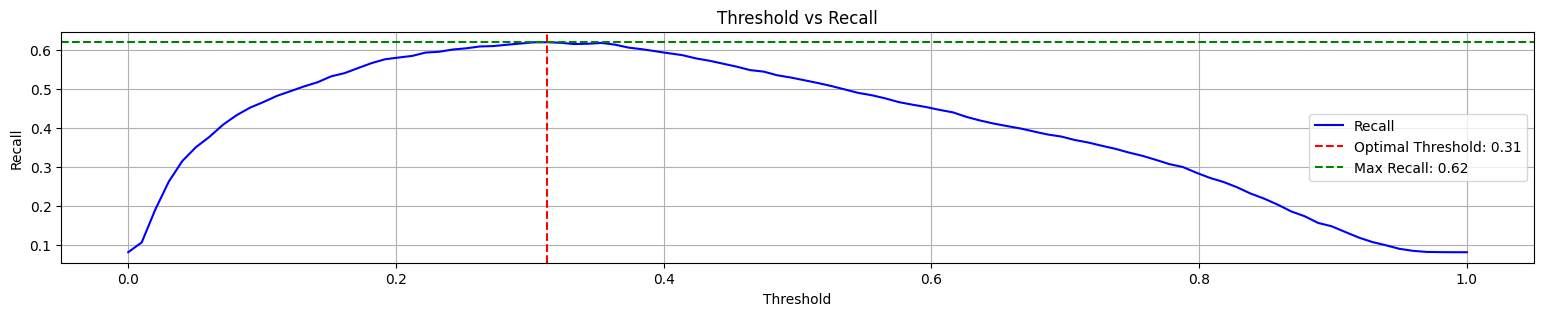

In [127]:
# Lista de thresholds para testar
thresholds = np.linspace(0, 1, 100)

# Listas vazias para armazenar as métricas
recall_values = []

# Loop pelos thresholds
for threshold in thresholds:
    # Predição usando o threshold atual
    y_pred_threshold = (y_pred_proba >= threshold).astype(int).argmax(axis = 1)
    # Calculando o recall
    recall = recall_score(y_teste, y_pred_threshold, average = 'weighted')
    recall_values.append(recall)

# Plotando o gráfico
plt.figure(figsize = (19, 3))
plt.plot(thresholds, recall_values, label = 'Recall', color = 'blue')
plt.title('Threshold vs Recall')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)

# Encontrando o threshold ótimo
optimal_threshold = thresholds[np.argmax(recall_values)]
max_recall = np.max(recall_values)

# Adicionando linha vertical no threshold ótimo
plt.axvline(x = optimal_threshold, color = 'red', linestyle = '--', label = f'Optimal Threshold: {optimal_threshold:.2f}')
# Adicionando linha horizontal no valor máximo de recall
plt.axhline(y = max_recall, color = 'green', linestyle = '--', label = f'Max Recall: {max_recall:.2f}')

plt.legend()
plt.show();

In [128]:
# Ajustando o threshold de decisão para melhorar o recall
threshold = optimal_threshold
y_pred_xgb = (y_pred_proba >= threshold).astype(int).argmax(1)

# Cálculo da acurácia
acuracia = accuracy_score(y_teste, y_pred_xgb)

# Cálculo da precisão
precisao = precision_score(y_teste, y_pred_xgb, average = 'weighted')

# Cálculo do recall
recall = recall_score(y_teste, y_pred_xgb, average = 'weighted')

# Cálculo da AUC
auc = roc_auc_score(y_teste, y_pred_proba, multi_class = 'ovr')

# Formatando as métricas para duas casas decimais e representação em porcentagem
acuracia_formatada = f'{acuracia*100:.2f}%'
precisao_formatada = f'{precisao*100:.2f}%'
recall_formatado = f'{recall*100:.2f}%'
auc_formatada = f'{auc:.2f}'

# Salvando em um dataframe
df_metricas = pd.DataFrame({'algoritmo': ['XGBoost'],
                            'acuracia': [acuracia_formatada], 
                            'precisao': [precisao_formatada], 
                            'recall': [recall_formatado], 
                            'auc': [auc_formatada]})

df_metricas

,algoritmo,acuracia,precisao,recall,auc
0,XGBoost,61.95%,61.79%,61.95%,0.83


# 9. (Avaliação do algoritmo) Passo 9: Performance do negócio ROI

* Para fins de simulação, foram estabelecidos valores de custo unitário de internação hospitalar para cada um dos rótulos da variável resposta.

In [129]:
# Criando o DataFrame
custo = pd.DataFrame({'custo_hospitalar': [50, 60, 80, 30, 90]}, 
                      index = ['(influenza) 0',
                               '(outro vírus respiratório) 1',
                               '(agente etiológico) 2',
                               '(não especificado) 3',
                               '(COVID-19) 4'])
# Renomeando o índice do DataFrame custo para 'SRAG'
custo.index.name = 'SRAG'

* Para avaliar qual modelo é melhor em termos de custo, iremos considerar o custo associado aos falsos negativos (quando o modelo não identifica corretamente um caso positivo). O recall representa a proporção de casos positivos que o modelo identifica corretamente em relação ao total de casos positivos reais. Portanto, um recall mais alto indica que o modelo está identificando mais casos positivos. Iremos multiplicar o número de falsos negativos de cada classe pelo custo associado a essa classe.

In [130]:
df_baseline_balanceado

,algoritmo,acuracia,precision,recall,auc
0,Média das classes,7.55%,0.57%,7.55%,0.50


In [131]:
df_metricas

,algoritmo,acuracia,precisao,recall,auc
0,XGBoost,61.95%,61.79%,61.95%,0.83


* Custo total associado aos falsos negativos para cada modelo

In [132]:
# Valor da métrica recall (5,83%)
custo['custo_media'] = custo['custo_hospitalar'] * (1 - 0.0583)

# Valor da métrica recall (48,96%)
custo['custo_xgboost'] = custo['custo_hospitalar'] * (1 - 0.5835)

In [133]:
# Calculando a diferença percentual entre custo_media e custo_xgboost
custo['dif_percentual'] = (1 - (custo['custo_xgboost'].sum() / custo['custo_media'].sum())) * 100
custo['dif_percentual'] = custo['dif_percentual'].round(2).astype(str) + '%'
custo.reset_index()

,SRAG,custo_hospitalar,custo_media,custo_xgboost,dif_percentual
0,(influenza) 0,50,47.085,20.825,55.77%
1,(outro vírus respiratório) 1,60,56.502,24.990,55.77%
2,(agente etiológico) 2,80,75.336,33.320,55.77%
3,(não especificado) 3,30,28.251,12.495,55.77%
4,(COVID-19) 4,90,84.753,37.485,55.77%


# 10. (Modelo em produção) Passo 10: Modelo em produção

### 10.1 Criar classe do projeto (salvar como script.py)

In [134]:
import os
import pickle
import pandas as pd

class Projeto:
    def __init__(self):        
        # Obs.: Este é o endereço local do arquivo (endereço absoluto)
        self.home_path = '/home/leonardo/projetos_/formulario_medico/transformacoes/'
        # Obs.: Este é o endereço na nuvem do arquivo (endereço relativo)
        # self.home_path = 'transformacoes/'
               
        # Carregando em memória as transformações
        self.cs_gestant_scaler = pickle.load(open(self.home_path + 'cs_gestant_scaler.pkl', 'rb'))
        self.cs_raca_scaler = pickle.load(open(self.home_path + 'cs_raca_scaler.pkl', 'rb'))
        self.cs_escol_n_scaler = pickle.load(open(self.home_path + 'cs_escol_n_scaler.pkl', 'rb'))
        self.cs_zona_scaler = pickle.load(open(self.home_path + 'cs_zona_scaler.pkl', 'rb'))
        self.nosocomial_scaler = pickle.load(open(self.home_path + 'nosocomial_scaler.pkl', 'rb'))
        self.ave_suino_scaler = pickle.load(open(self.home_path + 'ave_suino_scaler.pkl', 'rb'))
        self.febre_scaler = pickle.load(open(self.home_path + 'febre_scaler.pkl', 'rb'))
        self.tosse_scaler = pickle.load(open(self.home_path + 'tosse_scaler.pkl', 'rb'))
        self.garganta_scaler = pickle.load(open(self.home_path + 'garganta_scaler.pkl', 'rb'))
        self.dispneia_scaler = pickle.load(open(self.home_path + 'dispneia_scaler.pkl', 'rb'))
        self.desc_resp_scaler = pickle.load(open(self.home_path + 'desc_resp_scaler.pkl', 'rb'))
        self.saturacao_scaler = pickle.load(open(self.home_path + 'saturacao_scaler.pkl', 'rb'))
        self.diarreia_scaler = pickle.load(open(self.home_path + 'diarreia_scaler.pkl', 'rb'))
        self.vomito_scaler = pickle.load(open(self.home_path + 'vomito_scaler.pkl', 'rb'))
        self.puerpera_scaler = pickle.load(open(self.home_path + 'puerpera_scaler.pkl', 'rb'))
        self.cardiopati_scaler = pickle.load(open(self.home_path + 'cardiopati_scaler.pkl', 'rb'))
        self.hematologi_scaler = pickle.load(open(self.home_path + 'hematologi_scaler.pkl', 'rb'))
        self.sind_down_scaler = pickle.load(open(self.home_path + 'sind_down_scaler.pkl', 'rb'))
        self.hepatica_scaler = pickle.load(open(self.home_path + 'hepatica_scaler.pkl', 'rb'))
        self.asma_scaler = pickle.load(open(self.home_path + 'asma_scaler.pkl', 'rb'))
        self.diabetes_scaler = pickle.load(open(self.home_path + 'diabetes_scaler.pkl', 'rb'))
        self.neurologic_scaler = pickle.load(open(self.home_path + 'neurologic_scaler.pkl', 'rb'))        
        self.pneumopati_scaler = pickle.load(open(self.home_path + 'pneumopati_scaler.pkl', 'rb'))
        self.imunodepre_scaler = pickle.load(open(self.home_path + 'imunodepre_scaler.pkl', 'rb'))
        self.renal_scaler = pickle.load(open(self.home_path + 'renal_scaler.pkl', 'rb'))
        self.obesidade_scaler = pickle.load(open(self.home_path + 'obesidade_scaler.pkl', 'rb'))
        self.vacina_scaler = pickle.load(open(self.home_path + 'vacina_scaler.pkl', 'rb'))
        self.antiviral_scaler = pickle.load(open(self.home_path + 'antiviral_scaler.pkl', 'rb'))
        self.tp_antivir_scaler = pickle.load(open(self.home_path + 'tp_antivir_scaler.pkl', 'rb'))
        self.hospital_scaler = pickle.load(open(self.home_path + 'hospital_scaler.pkl', 'rb'))
        self.uti_scaler = pickle.load(open(self.home_path + 'uti_scaler.pkl', 'rb'))
        self.suport_ven_scaler = pickle.load(open(self.home_path + 'suport_ven_scaler.pkl', 'rb'))
        self.raiox_res_scaler = pickle.load(open(self.home_path + 'raiox_res_scaler.pkl', 'rb'))
        self.tp_amostra_scaler = pickle.load(open(self.home_path + 'tp_amostra_scaler.pkl', 'rb'))        
        self.dor_abd_scaler = pickle.load(open(self.home_path + 'dor_abd_scaler.pkl', 'rb'))
        self.fadiga_scaler = pickle.load(open(self.home_path + 'fadiga_scaler.pkl', 'rb'))
        self.perd_olft_scaler = pickle.load(open(self.home_path + 'perd_olft_scaler.pkl', 'rb'))
        self.perd_pala_scaler = pickle.load(open(self.home_path + 'perd_pala_scaler.pkl', 'rb'))
        self.tomo_res_scaler = pickle.load(open(self.home_path + 'tomo_res_scaler.pkl', 'rb'))
        self.vacina_cov_scaler = pickle.load(open(self.home_path + 'vacina_cov_scaler.pkl', 'rb'))
        self.dose_1_cov_scaler = pickle.load(open(self.home_path + 'dose_1_cov_scaler.pkl', 'rb'))
        self.dose_2_cov_scaler = pickle.load(open(self.home_path + 'dose_2_cov_scaler.pkl', 'rb'))
        self.dose_ref_scaler = pickle.load(open(self.home_path + 'dose_ref_scaler.pkl', 'rb'))
        self.idade_anos_scaler = pickle.load(open(self.home_path + 'idade_anos_scaler.pkl', 'rb'))
        
        # Carregando em memória os encoders
        self.sg_uf_not_encoder = pickle.load(open(self.home_path + 'sg_uf_not_encoder.pkl', 'rb'))
        self.cs_sexo_encoder = pickle.load(open(self.home_path + 'cs_sexo_encoder.pkl', 'rb'))

    def limpeza_dos_dados(self, df1):
        # Convertendo em minúsculas
        df1.columns = df1.columns.str.lower()

        # Substituir NA's
        df1['cs_gestant'] = df1['cs_gestant'].apply(lambda x: x if x in [1, 2, 3, 4, 5, 6, 9] else 9)
        df1.loc[df1['cs_sexo'] == 'M', 'cs_gestant'] = 6
        df1['ave_suino'] = df1['ave_suino'].apply(lambda x: x if x in [1, 2, 9] else 9)
        df1.loc[df1['tp_antivir'] == 9, 'tp_antivir'] = 3
        df1.loc[df1['hospital'] == 3, 'hospital'] = 9
        df1.loc[df1['uti'] == 3, 'uti'] = 9
        df1['tp_antivir'] = df1.apply(lambda x: 3 if pd.isna(x['tp_antivir']) and x['antiviral'] == 1 else x['tp_antivir'], axis = 1)
        df1['tp_antivir'] = df1.apply(lambda x: 0 if pd.isna(x['tp_antivir']) and (x['antiviral'] == 2 or x['antiviral'] == 9) else x['tp_antivir'], axis = 1)

        # Excluir NA's
        df1 = df1[df1['cs_sexo'].isin(['M', 'F'])]
        df1 = df1[df1['amostra'].isin([1, 2, 9])]
        df1 = df1[df1['tp_amostra'].isin([1, 2, 3, 4, 5, 9])]
        df1 = df1[df1['classi_fin'].isin([1, 2, 3, 4, 5])]
        df1 = df1[df1['dose_1_cov'].isin([0, 1])]
        df1 = df1[df1['dose_ref'].isin([0, 1])]        
        
        # Inserindo 9 - Não aplicável nas linhas com NaN
        colunas_a_preencher = ['cs_escol_n', 'cs_zona', 'nosocomial', 'febre', 'tosse', 'garganta',
                               'dispneia', 'desc_resp', 'saturacao', 'diarreia', 'vomito', 'dor_abd',
                               'fadiga', 'perd_olft', 'perd_pala', 'cardiopati', 'hematologi', 'sind_down',
                               'hepatica', 'asma', 'diabetes', 'neurologic', 'pneumopati', 'imunodepre',
                               'renal', 'obesidade', 'vacina', 'antiviral', 'hospital', 'uti', 'suport_ven',
                               'raiox_res', 'tomo_res', 'vacina_cov', 'dose_2_cov']
        
        # Criando um dicionário com o valor 9 para todas as colunas
        valores_a_preencher = {coluna: 9 for coluna in colunas_a_preencher}
        
        # Preenchendo os valores nulos
        df1 = df1.fillna(valores_a_preencher)
        return df1

    def engenharia_de_variaveis(self, df2):
       # Convertendo o tipo de idade (em dias e meses) para anos
        df2['idade_anos'] = df2.apply(lambda row: row['nu_idade_n'] / 365 if row['tp_idade'] == 1 else 
                                                  row['nu_idade_n'] * 12 if row['tp_idade'] == 2 else 
                                                  row['nu_idade_n'], axis = 1)
        
        # Eliminando as colunas que foram derivadas
        df2 = df2.drop(columns = ['nu_idade_n', 'tp_idade'], axis = 1)
        
        # Ajustando os rótulos da variável resposta para sejam aceitas no algoritmo xgboost        
        # Criando um mapeamento de valores antigos para novos valores da variável resposta
        mapeamento = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
        df2['classi_fin'] = df2['classi_fin'].map(mapeamento)
        
        # Lista original de colunas
        nome_colunas = ['sg_uf_not', 'id_municip', 'cs_sexo', 'cs_gestant', 'cs_raca',
                        'cs_escol_n', 'cs_zona', 'nosocomial', 'ave_suino', 'febre', 'tosse',
                        'garganta', 'dispneia', 'desc_resp', 'saturacao', 'diarreia', 'vomito',
                        'puerpera', 'fator_risc', 'cardiopati', 'hematologi', 'sind_down',
                        'hepatica', 'asma', 'diabetes', 'neurologic', 'pneumopati',
                        'imunodepre', 'renal', 'obesidade', 'vacina', 'antiviral', 'tp_antivir',
                        'hospital', 'uti', 'suport_ven', 'raiox_res', 'amostra', 'tp_amostra',
                        'classi_fin', 'dor_abd', 'fadiga', 'perd_olft', 'perd_pala', 'tomo_res',
                        'vacina_cov', 'dose_1_cov', 'dose_2_cov', 'dose_ref', 'idade_anos']
        
        # Removendo 'classi_fin' da lista
        nome_colunas.remove('classi_fin')
        
        # Adicionando 'classi_fin' ao final da lista
        nome_colunas.append('classi_fin')
        
        # Reorganizando as colunas do DataFrame
        df2 = df2.reindex(columns = nome_colunas)
 
        # Como a variância das colunas 'amostra' e 'fator_risc' são iguais a zero, estas variáveis serão excluidas
        df2 = df2.drop(columns = ['amostra', 'fator_risc', 'id_municip'], axis = 1)
        return df2
        
    def transformacao_dos_dados(self, df5):
        # Aplicando MinMaxScaler
        df5['cs_gestant'] = self.cs_gestant_scaler.transform(df5[['cs_gestant']].values)
        df5['cs_raca'] = self.cs_raca_scaler.transform(df5[['cs_raca']].values)
        df5['cs_escol_n'] = self.cs_escol_n_scaler.transform(df5[['cs_escol_n']].values)
        df5['cs_zona'] = self.cs_zona_scaler.transform(df5[['cs_zona']].values)
        df5['nosocomial'] = self.nosocomial_scaler.transform(df5[['nosocomial']].values)
        df5['ave_suino'] = self.ave_suino_scaler.transform(df5[['ave_suino']].values)
        df5['febre'] = self.febre_scaler.transform(df5[['febre']].values)
        df5['tosse'] = self.tosse_scaler.transform(df5[['tosse']].values)
        df5['garganta'] = self.garganta_scaler.transform(df5[['garganta']].values)
        df5['dispneia'] = self.dispneia_scaler.transform(df5[['dispneia']].values)
        df5['desc_resp'] = self.desc_resp_scaler.transform(df5[['desc_resp']].values)
        df5['saturacao'] = self.saturacao_scaler.transform(df5[['saturacao']].values)
        df5['diarreia'] = self.diarreia_scaler.transform(df5[['diarreia']].values)
        df5['vomito'] = self.vomito_scaler.transform(df5[['vomito']].values)
        df5['puerpera'] = self.puerpera_scaler.transform(df5[['puerpera']].values)
        df5['cardiopati'] = self.cardiopati_scaler.transform(df5[['cardiopati']].values)
        df5['hematologi'] = self.hematologi_scaler.transform(df5[['hematologi']].values)
        df5['sind_down'] = self.sind_down_scaler.transform(df5[['sind_down']].values)
        df5['hepatica'] = self.hepatica_scaler.transform(df5[['hepatica']].values)
        df5['asma'] = self.asma_scaler.transform(df5[['asma']].values)
        df5['diabetes'] = self.diabetes_scaler.transform(df5[['diabetes']].values)
        df5['neurologic'] = self.neurologic_scaler.transform(df5[['neurologic']].values)
        df5['pneumopati'] = self.pneumopati_scaler.transform(df5[['pneumopati']].values)
        df5['imunodepre'] = self.imunodepre_scaler.transform(df5[['imunodepre']].values)
        df5['renal'] = self.renal_scaler.transform(df5[['renal']].values)
        df5['obesidade'] = self.obesidade_scaler.transform(df5[['obesidade']].values)
        df5['vacina'] = self.vacina_scaler.transform(df5[['vacina']].values)
        df5['antiviral'] = self.antiviral_scaler.transform(df5[['antiviral']].values)
        df5['tp_antivir'] = self.tp_antivir_scaler.transform(df5[['tp_antivir']].values)
        df5['hospital'] = self.hospital_scaler.transform(df5[['hospital']].values)
        df5['uti'] = self.uti_scaler.transform(df5[['uti']].values)
        df5['suport_ven'] = self.suport_ven_scaler.transform(df5[['suport_ven']].values)
        df5['raiox_res'] = self.raiox_res_scaler.transform(df5[['raiox_res']].values)
        df5['tp_amostra'] = self.tp_amostra_scaler.transform(df5[['tp_amostra']].values)
        df5['dor_abd'] = self.dor_abd_scaler.transform(df5[['dor_abd']].values)
        df5['fadiga'] = self.fadiga_scaler.transform(df5[['fadiga']].values)
        df5['perd_olft'] = self.perd_olft_scaler.transform(df5[['perd_olft']].values)
        df5['perd_pala'] = self.perd_pala_scaler.transform(df5[['perd_pala']].values)
        df5['tomo_res'] = self.tomo_res_scaler.transform(df5[['tomo_res']].values)
        df5['vacina_cov'] = self.vacina_cov_scaler.transform(df5[['vacina_cov']].values)
        df5['dose_1_cov'] = self.dose_1_cov_scaler.transform(df5[['dose_1_cov']].values)
        df5['dose_2_cov'] = self.dose_2_cov_scaler.transform(df5[['dose_2_cov']].values)
        df5['dose_ref'] = self.dose_ref_scaler.transform(df5[['dose_ref']].values)
        df5['idade_anos'] = self.idade_anos_scaler.transform(df5[['idade_anos']].values)

        # Aplicando LabelEncoder
        df5['sg_uf_not'] = self.sg_uf_not_encoder.transform(df5[['sg_uf_not']].values)
        df5['cs_sexo'] = self.cs_sexo_encoder.transform(df5[['cs_sexo']].values)

        colunas_selecionadas = ['idade_anos', 'tomo_res', 'sg_uf_not',
                                'raiox_res', 'cs_escol_n', 'suport_ven',
                                'cs_raca', 'vacina_cov', 'antiviral', 'asma', 
                                'dose_2_cov', 'dose_ref', 'tp_antivir',
                                'vacina', 'dose_1_cov', 'tp_amostra']
        return df5[colunas_selecionadas]

    def get_prediction(self, modelo, dados_originais, dados_teste):
        pred = modelo.predict(dados_teste)
        dados_originais['classificacao'] = pred
        return dados_originais.to_json(orient = 'records', date_format = 'iso')

### 10.2 Criar API (salvar como api_handler.py)

In [135]:
import pickle
import os
import pandas as pd
from flask import Flask, request, Response

#Diretório onde está salvo a API handler.py
#Nome do arquivo.py
#Nome da classe que foi criada dentro do arquivo.py

#from Diretório.arquivo        import classe
from script import Projeto

# Carregando o modelo treinado usando pickle
# Obs.: Este é o endereço local do arquivo (endereço absoluto)
modelo = pickle.load(open('/home/leonardo/projetos_/formulario_medico/modelo/modelo_treinado.pkl', 'rb'))
# Obs.: Este é o endereço na nuvem do arquivo (endereço relativo)
# modelo = pickle.load(open('modelo/modelo_treinado.pkl', 'rb'))

app = Flask(__name__)

@app.route('/')
def index():
    return 'Servidor Flask está funcionando normalmente!'

@app.route('/predict', methods = ['POST'])
def predict():
    teste_json = request.get_json() # Recebe um arquivo JSON a partir da request

    if teste_json:  # Se o teste_json for diferente de vazio, ou seja, se foi carregado algum dado
        # Verifica se o arquivo passado é um tipo de dicionário e se sim, foi enviado um arquivo com somente uma linha
        if isinstance(teste_json, dict):
            # Cria um dataframe e para isso é necessário indicar no Pandas qual é o nº da linha inicial, nesta caso, 0
            dados_brutos_que_vieram_da_producao = pd.DataFrame(teste_json, index = [0])
        else:
            # Se não for é um dicionário, foi enviado um arquivo com mais de uma linha
            dados_brutos_que_vieram_da_producao = pd.DataFrame(teste_json, columns = teste_json[0].keys())

        # Instanciando a classe do projeto
        pipeline = Projeto()
        
        # Limpeza_dos_dados
        df1 = pipeline.limpeza_dos_dados(dados_brutos_que_vieram_da_producao)
        
        # Engenharia_de_atributos
        df2 = pipeline.engenharia_de_variaveis(df1)

        # Transformação dos dados
        df5 = pipeline.transformacao_dos_dados(df2)
        
        # Predição
        df_resposta = pipeline.get_prediction(modelo, dados_brutos_que_vieram_da_producao, df5)
        
        return df_resposta
    else:
        return Response('{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__':
    # Dizer para endpoint rodar no localhost (rodando na máquina)
    # port = os.environ.get('PORT', 5000)
    # app.run('0.0.0.0', port = port)
    app.run('0.0.0.0', debug = False)

ModuleNotFoundError: No module named 'script'

### 10.3 Testar a API

In [147]:
dados = dados_brutos_que_vieram_da_producao.tail(2)

In [148]:
dados

,SG_UF_NOT,ID_MUNICIP,CS_SEXO,NU_IDADE_N,TP_IDADE,CS_GESTANT,CS_RACA,CS_ESCOL_N,CS_ZONA,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,PUERPERA,FATOR_RISC,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,VACINA,ANTIVIRAL,TP_ANTIVIR,HOSPITAL,UTI,SUPORT_VEN,RAIOX_RES,AMOSTRA,TP_AMOSTRA,CLASSI_FIN,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,VACINA_COV,DOSE_1_COV,DOSE_2_COV,DOSE_REF
1300978,RN,NATAL,M,39,3,6,4,9.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,1,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,9.0,2.0,NaN,1.0,1.0,1.0,5.0,1.0,1.0,3,2.0,1.0,2.0,2.0,NaN,2.0,0,0,0
1300979,SP,BOTUCATU,M,85,3,6,1,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,9.0,2.0,NaN,1.0,2.0,2.0,6.0,1.0,1.0,3,1.0,2.0,2.0,2.0,3.0,1.0,1,1,0


In [149]:
import pandas as pd
import json
import requests

# Dados de teste fornecidos
#dados = {'SG_UF_NOT': ['SP', 'PA'], 'ID_MUNICIP': ['SOROCABA', 'BELEM'], 'CS_SEXO': ['F', 'M'], 'NU_IDADE_N': [85, 46], 'TP_IDADE': [3, 3], 'CS_GESTANT': [6, 6], 'CS_RACA': [1, 1],
#         'CS_ESCOL_N': [9.0, 1.0], 'CS_ZONA': [2.0, 2.0], 'NOSOCOMIAL': [2.0, 2.0], 'AVE_SUINO': [2.0, 2.0], 'FEBRE': [2.0, 2.0], 'TOSSE': [2.0, 2.0], 'GARGANTA': [2.0, 2.0],
#         'DISPNEIA': [1.0, 1.0], 'DESC_RESP': [1.0, 1.0], 'SATURACAO': [1.0, 1.0], 'DIARREIA': [2.0, 1.0], 'VOMITO': [2.0, 1.0], 'PUERPERA': [2.0, 1.0], 'FATOR_RISC': [1, 1],
#         'CARDIOPATI': [1.0, 1.0], 'HEMATOLOGI': [2.0, 1.0], 'SIND_DOWN': [2.0, 1.0], 'HEPATICA': [2.0, 1.0], 'ASMA': [1.0, 1.0], 'DIABETES': [1.0, 1.0], 'NEUROLOGIC': [1.0, 1.0],
#         'PNEUMOPATI': [9.0, 1.0], 'IMUNODEPRE': [2.0, 1.0], 'RENAL': [2.0, 1.0], 'OBESIDADE': [1.0, 1.0], 'VACINA': [2.0, 1.0], 'ANTIVIRAL': [2.0, 1.0], 'TP_ANTIVIR': [None, None],
#         'HOSPITAL': [1.0, 1.0], 'UTI': [2.0, 1.0], 'SUPORT_VEN': [2.0, 1.0], 'RAIOX_RES': [1.0, 1.0], 'AMOSTRA': [1.0, 1.0], 'TP_AMOSTRA': [1.0, 1.0], 'CLASSI_FIN': [4, 5], 'DOR_ABD': [2.0, 1.0],
#         'FADIGA': [1.0, 1.0], 'PERD_OLFT': [2.0, 1.0], 'PERD_PALA': [2.0, 1.0], 'TOMO_RES': [6.0, 1.0], 'VACINA_COV': [2.0, 1.0], 'DOSE_1_COV': [0, 0], 'DOSE_2_COV': [0, 0], 'DOSE_REF': [0, 0]}

# Criando o DataFrame
#df_teste = pd.DataFrame(dados)
#data = df_teste.to_json(orient = 'records')

# Convertendo o DataFrame em formato JSON
data = dados.to_json(orient = 'records')

In [150]:
# Chamando a API
# url = 'https://health-insurance-ixwn.onrender.com/predict' # Este é o novo endereço a partir da nuvem
url = 'http://0.0.0.0:5000/predict' # Endpoint -> 0.0.0.0 é a máquina local e :5000 é a porta padrão da biblioteca flask
header = {'Content-type': 'application/json'} # Indica para o API qual tipo de dado ele está recebendo, ou seja, estamos enviando JSON
data = data # Dados
r = requests.post(url, data, headers = header) # Fazendo a chamada POST para a API
print('Status Code {}'.format(r.status_code))

Status Code 200


#### 10.3.1 Predição

In [151]:
predicao = pd.DataFrame(r.json(), columns = r.json()[0].keys())

# Retornando o ajuste dos rótulos da variável resposta para que representem os dados originais        
# Criando um mapeamento de valores antigos para novos valores da variável resposta
mapeamento = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}
predicao['classificacao'] = predicao['classificacao'].map(mapeamento)

predicao

,sg_uf_not,id_municip,cs_sexo,nu_idade_n,tp_idade,cs_gestant,cs_raca,cs_escol_n,cs_zona,nosocomial,ave_suino,febre,tosse,garganta,dispneia,desc_resp,saturacao,diarreia,vomito,puerpera,fator_risc,cardiopati,hematologi,sind_down,hepatica,asma,diabetes,neurologic,pneumopati,imunodepre,renal,obesidade,vacina,antiviral,tp_antivir,hospital,uti,suport_ven,raiox_res,amostra,tp_amostra,classi_fin,dor_abd,fadiga,perd_olft,perd_pala,tomo_res,vacina_cov,dose_1_cov,dose_2_cov,dose_ref,classificacao
0,RN,NATAL,M,39,3,6,4,9.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,1,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,9.0,2.0,0,1.0,1.0,1.0,5.0,1.0,1.0,3,2.0,1.0,2.0,2.0,NaN,2.0,0,0,0,5
1,SP,BOTUCATU,M,85,3,6,1,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,9.0,2.0,0,1.0,2.0,2.0,6.0,1.0,1.0,3,1.0,2.0,2.0,2.0,3.0,1.0,1,1,0,3
